<a href="https://colab.research.google.com/github/BeBrave-BeHumble/Real_Data_Analysis/blob/main/Loan_Repayment_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Repayment Prediction Model

The objective here is to build a model, primarily using a publicly available dataset from American microloan companies, to predict whether borrowers will fully repay their loans or not.


A total of 7,000 samples are provided for training, with each sample containing 13 features that can be used for model training and the final outcome (whether the loan has been fully repaid) provided as the label.

## Dataset Describtion

1. train.csv
2. test.csv

The formats of the two files are identical, except that the former contains a label field, while the latter includes an ID field for each record but does not have a label field.

### 1. Train Set
In 'train.csv,' there are a total of 7,000 training examples (excluding the CSV file header). Each example is provided with 13 fields as features, with the last field representing the label 'notfullypaid.' Below is a detailed description of the 13 fields and the label.

|   필드                |   설명                                                                                                                                                               |
|:-----------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|   policy              |   1 indicates that the borrower meets the criteria set by the lending company, while 0 signifies that they do not meet the criteria.                                                                       |
|   purpose             |   Represents the purpose of the loan. Possible values include:  <br> "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", "home_improvement", "all_other".       |
|   intrate             |   Indicates the interest rate of the loan. An 11% interest rate is represented as 0.11. Lending companies may assign higher interest rates to borrowers they believe may have difficulty repaying the loan.                              |
|   installment         |   The monthly installments owed by the borrower if the loan is funded.                                                                                                                                              |
|   annualincome        |   The annual income reported by the borrower, represented in logarithmic form.                                                                                                                          |
|   dti                 |   The borrower's debt-to-income ratio. The income value comes from the 'annualincome' column mentioned earlier.                                                                                        |
|   fico                |   The borrower's credit score. A higher value indicates better creditworthiness                                                                                                     |
|   dayswithcreditline  |   The number of days the borrower has had a credit line since opening a credit card                                                                                                                         |
|   balance             |   The remaining unpaid balance on the borrower's credit card                                                                                                                            |
|   balanceutil         |   The ratio of the borrower's credit card credit limit used. For example, if the credit limit is 10 million won and the current outstanding balance is 1 million won, this ratio would be 0.10.                             |
|   inqlast6mths        |   The number of inquiries made by various creditors regarding the borrower's creditworthiness in the past 6 months                                                                                                  |
|   delinq2yrs          |   The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                                                                      |
|   pubrec              |   The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments)                                                                   |
|   notfullypaid        |   This is the label indicating whether the loan should be repaid based on the features described above. 0 means the loan has been fully repaid, and 1 means it has not been fully repaid.  |

So, have to predict 'notfullypaid' based on the 13 features

### 2. Test Set

The structure of this file is similar to train.csv, consisting of one header line and 2578 lines of feature data.

The difference is that test.csv does not have the 'notfullypaid' field, which represents loan repayment status, unlike train.csv. Instead, it includes an ID field as the first field, which corresponds to the serial number, but is otherwise identical to train.csv.

## Preferences

- 다양한 환경에서 실행하기 위한 ROOT_DIR, DATA_ROOT_DIR등을 설정함
- ROOT_DIR, CUSTOM_DATA_NAME 설정

In [1]:
ROOT_DIR = '/content' # Colab root dir

- DATA_ROOT_DIR 설정

In [2]:
import os

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Loan_Data') # Data root

print(DATA_ROOT_DIR, type(DATA_ROOT_DIR))

/content/Loan_Data <class 'str'>


## Data Road

- 구글 드라이브 마운트

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/MyDrive/CodingTest/data_science'

    shutil.copy(os.path.join(dataset_path, 'loan_archive.zip'), '/content')

except Exception as err:
    print(str(err))

In [5]:
if os.path.exists(DATA_ROOT_DIR):

    shutil.rmtree(DATA_ROOT_DIR)

    print(DATA_ROOT_DIR + 'is removed!' )



- 압축파일 풀기

In [6]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'loan_archive.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR)

In [7]:
DATA_ROOT_DIR

'/content/Loan_Data'

## Preprocssing

In [8]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np
import time

In [9]:
import pandas as pd

loan_data = pd.read_csv(os.path.join(DATA_ROOT_DIR, 'loan_data.csv'))

In [10]:
loan_data.head()

credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

In [11]:
loan_data.describe()

credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.000000         178.958333  0.000000e+00     0.000000   
25%     682.000000        2820.000000  3.187000e+03    22.600000   
50%     707.000000        4139.958333  8.596000e+03    46.300000   
75%     737.000000        5730.000000  1.824950e+04    70.900000   
max     827.000000       17639.958330  1.207359e+06   119.000000   

       inq.last.6mths  delinq.2yrs      pub.rec  not.fully.paid  
count     9578.000000  9578.000000  9578.000000     9578.000000  
mean         1.577469     0.163708     0.062122        0.160054  
std          2.200245     0.546215     0.262126        0.366676  
min          0.000000     0.000000     0.000000        0.000000  
25%          0.000000     0.000000     0.000000        0.000000  
50%          1.000000     0.000000     0.000000        0.000000  
75%          2.000000     0.000000     0.000000        0.000000  
max         33.000000    13.000000     5.000000        1.000000

- 변수명 바꾸기

In [12]:
loan_data = loan_data.rename(columns = {'credit.policy':'credit_policy', 'int.rate':'int_rate', 'log.annual.inc':'log_annual_inc',
                            'days.with.cr.line':'days_with_cr_line', 'revol.bal':'revol_bal', 'revol.util':'revol_util',
                            'inq.last.6mths':'inq_last_6mths', 'delinq.2yrs':'delinq_2yrs', 'pub.rec':'pub_rec',
                            'not.fully.paid':'not_fully_paid'})

- PK로 쓸 id 생성

In [13]:
loan_data.reset_index(inplace = True)

In [14]:
loan_data.head()

index  credit_policy             purpose  int_rate  installment  \
0      0              1  debt_consolidation    0.1189       829.10   
1      1              1         credit_card    0.1071       228.22   
2      2              1  debt_consolidation    0.1357       366.86   
3      3              1  debt_consolidation    0.1008       162.34   
4      4              1         credit_card    0.1426       102.92   

   log_annual_inc    dti  fico  days_with_cr_line  revol_bal  revol_util  \
0       11.350407  19.48   737        5639.958333      28854        52.1   
1       11.082143  14.29   707        2760.000000      33623        76.7   
2       10.373491  11.63   682        4710.000000       3511        25.6   
3       11.350407   8.10   712        2699.958333      33667        73.2   
4       11.299732  14.97   667        4066.000000       4740        39.5   

   inq_last_6mths  delinq_2yrs  pub_rec  not_fully_paid  
0               0            0        0               0  
1               0            0        0               0  
2               1            0        0               0  
3               1            0        0               0  
4               0            1        0               0

In [15]:
# 변수명 바꾸기

loan_data = loan_data.rename(columns = {'index':'id'})

In [16]:
loan_data.head()

id  credit_policy             purpose  int_rate  installment  \
0   0              1  debt_consolidation    0.1189       829.10   
1   1              1         credit_card    0.1071       228.22   
2   2              1  debt_consolidation    0.1357       366.86   
3   3              1  debt_consolidation    0.1008       162.34   
4   4              1         credit_card    0.1426       102.92   

   log_annual_inc    dti  fico  days_with_cr_line  revol_bal  revol_util  \
0       11.350407  19.48   737        5639.958333      28854        52.1   
1       11.082143  14.29   707        2760.000000      33623        76.7   
2       10.373491  11.63   682        4710.000000       3511        25.6   
3       11.350407   8.10   712        2699.958333      33667        73.2   
4       11.299732  14.97   667        4066.000000       4740        39.5   

   inq_last_6mths  delinq_2yrs  pub_rec  not_fully_paid  
0               0            0        0               0  
1               0            0        0               0  
2               1            0        0               0  
3               1            0        0               0  
4               0            1        0               0

In [17]:
# 나중에 결과 확인 용 ID 복제
loan_data['id_check'] = loan_data[['id']]

In [18]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 9578 non-null   int64  
 1   credit_policy      9578 non-null   int64  
 2   purpose            9578 non-null   object 
 3   int_rate           9578 non-null   float64
 4   installment        9578 non-null   float64
 5   log_annual_inc     9578 non-null   float64
 6   dti                9578 non-null   float64
 7   fico               9578 non-null   int64  
 8   days_with_cr_line  9578 non-null   float64
 9   revol_bal          9578 non-null   int64  
 10  revol_util         9578 non-null   float64
 11  inq_last_6mths     9578 non-null   int64  
 12  delinq_2yrs        9578 non-null   int64  
 13  pub_rec            9578 non-null   int64  
 14  not_fully_paid     9578 non-null   int64  
 15  id_check           9578 non-null   int64  
dtypes: float64(6), int64(9),

### Split

- X_train: 약 7,000개, 예측모델 만드는 데 활용
- Y_train: 약 7,000개, 예측모델 만드는 데 활용
- X_test: 모델 만든 후 예측에 활용
- Y_test: 실제 결과값

In [19]:
target = loan_data[['not_fully_paid', 'id_check']]
features = loan_data.drop(['not_fully_paid', 'id_check'], axis = 1)

In [20]:
target.head()

not_fully_paid  id_check
0               0         0
1               0         1
2               0         2
3               0         3
4               0         4

In [21]:
features.head()

id  credit_policy             purpose  int_rate  installment  \
0   0              1  debt_consolidation    0.1189       829.10   
1   1              1         credit_card    0.1071       228.22   
2   2              1  debt_consolidation    0.1357       366.86   
3   3              1  debt_consolidation    0.1008       162.34   
4   4              1         credit_card    0.1426       102.92   

   log_annual_inc    dti  fico  days_with_cr_line  revol_bal  revol_util  \
0       11.350407  19.48   737        5639.958333      28854        52.1   
1       11.082143  14.29   707        2760.000000      33623        76.7   
2       10.373491  11.63   682        4710.000000       3511        25.6   
3       11.350407   8.10   712        2699.958333      33667        73.2   
4       11.299732  14.97   667        4066.000000       4740        39.5   

   inq_last_6mths  delinq_2yrs  pub_rec  
0               0            0        0  
1               0            0        0  
2               1            0        0  
3               1            0        0  
4               0            1        0

In [22]:
print(features.shape, '//', target.shape)
print(features.shape[0]*0.25, '//', features.shape[0]*0.75)

(9578, 14) // (9578, 2)
2394.5 // 7183.5


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test =  train_test_split(features, target, test_size = 0.25, random_state = 56,
                                                     shuffle = True, stratify = target['not_fully_paid']) # 7000:2500개 정도로 맞추고 싶어서 0.25:0.75 사용

In [24]:
print('features: ', X_train.shape, '//', X_test.shape)
print('target: ', Y_train.shape, '//', Y_test.shape)

features:  (7183, 14) // (2395, 14)
target:  (7183, 2) // (2395, 2)


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 8714 to 1530
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7183 non-null   int64  
 1   credit_policy      7183 non-null   int64  
 2   purpose            7183 non-null   object 
 3   int_rate           7183 non-null   float64
 4   installment        7183 non-null   float64
 5   log_annual_inc     7183 non-null   float64
 6   dti                7183 non-null   float64
 7   fico               7183 non-null   int64  
 8   days_with_cr_line  7183 non-null   float64
 9   revol_bal          7183 non-null   int64  
 10  revol_util         7183 non-null   float64
 11  inq_last_6mths     7183 non-null   int64  
 12  delinq_2yrs        7183 non-null   int64  
 13  pub_rec            7183 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 841.8+ KB


In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 1396 to 8371
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2395 non-null   int64  
 1   credit_policy      2395 non-null   int64  
 2   purpose            2395 non-null   object 
 3   int_rate           2395 non-null   float64
 4   installment        2395 non-null   float64
 5   log_annual_inc     2395 non-null   float64
 6   dti                2395 non-null   float64
 7   fico               2395 non-null   int64  
 8   days_with_cr_line  2395 non-null   float64
 9   revol_bal          2395 non-null   int64  
 10  revol_util         2395 non-null   float64
 11  inq_last_6mths     2395 non-null   int64  
 12  delinq_2yrs        2395 non-null   int64  
 13  pub_rec            2395 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 280.7+ KB


In [27]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 8714 to 1530
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   not_fully_paid  7183 non-null   int64
 1   id_check        7183 non-null   int64
dtypes: int64(2)
memory usage: 168.4 KB


In [28]:
Y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 1396 to 8371
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   not_fully_paid  2395 non-null   int64
 1   id_check        2395 non-null   int64
dtypes: int64(2)
memory usage: 56.1 KB


In [29]:
X_train.describe()

id  credit_policy     int_rate  installment  log_annual_inc  \
count  7183.000000    7183.000000  7183.000000  7183.000000     7183.000000   
mean   4775.907838       0.805791     0.122474   317.796052       10.928639   
std    2774.574408       0.395618     0.026795   207.153118        0.618944   
min       0.000000       0.000000     0.060000    15.670000        7.547502   
25%    2349.500000       1.000000     0.103900   162.010000       10.545341   
50%    4800.000000       1.000000     0.122100   267.290000       10.915088   
75%    7173.500000       1.000000     0.140700   432.945000       11.302204   
max    9577.000000       1.000000     0.212100   940.140000       14.528354   

               dti         fico  days_with_cr_line     revol_bal   revol_util  \
count  7183.000000  7183.000000        7183.000000  7.183000e+03  7183.000000   
mean     12.576364   711.105527        4572.209244  1.699933e+04    46.539830   
std       6.910338    38.104869        2508.542108  3.548478e+04    28.998644   
min       0.000000   612.000000         178.958333  0.000000e+00     0.000000   
25%       7.150000   682.000000        2820.041667  3.131500e+03    22.200000   
50%      12.630000   707.000000        4140.000000  8.575000e+03    45.700000   
75%      17.940000   737.000000        5700.500000  1.812350e+04    70.900000   
max      29.960000   822.000000       17639.958330  1.207359e+06   108.800000   

       inq_last_6mths  delinq_2yrs      pub_rec  
count     7183.000000  7183.000000  7183.000000  
mean         1.573577     0.160657     0.063901  
std          2.191947     0.548485     0.261113  
min          0.000000     0.000000     0.000000  
25%          0.000000     0.000000     0.000000  
50%          1.000000     0.000000     0.000000  
75%          2.000000     0.000000     0.000000  
max         33.000000    13.000000     4.000000

In [30]:
# ID 필드 분리하기

X_test_id = X_test[['id']] # 우리가 필요한 건 이거 하나
X_train_id = X_train[['id']]
Y_train_id = Y_train[['id_check']]

X_train = X_train.drop(['id'], axis = 1)
X_test = X_test.drop(['id'], axis = 1)
Y_train = Y_train.drop(['id_check'], axis = 1) # target 변수만 있으면 됨

In [31]:
# 백업 데이터 생성

X_train_back = X_train
X_test_back = X_test
Y_train_back = Y_train

### Overlook on Data

In [32]:
print("Records: ", X_train.shape[0], "\nFeatures: ", X_train.shape[1])
print("Records: ", Y_train.shape[0], "\nFeatures: ", Y_train.shape[1])

Records:  7183 
Features:  13
Records:  7183 
Features:  1


#### Features

각 feature를 다음과 같은 절차로 개별적으로 검토:

- 요약 통계 정보, 데이터 시각화, target 변수에 대해 플로팅.
- '신용도(FICO)'가 대출 상환과 가장 큰 연관이 있을 것이라 판단됨. 따라서 신용도+target 변수와의 관계도 살펴볼 것.
- target을 예측하는 데 유용하지 않은 feature는 삭제.
- 모델링에 유용하도록 필요한 경우 feature를 수정.

In [33]:
X_train.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')

In [34]:
mydat = concat3 = pd.concat([X_train, Y_train], axis=1)

In [35]:
mydat.head()

credit_policy             purpose  int_rate  installment  \
8714              0  debt_consolidation    0.1418        95.95   
1007              1  debt_consolidation    0.0945       160.05   
4502              1  debt_consolidation    0.1635       559.97   
3891              1  debt_consolidation    0.1253       133.87   
877               1         credit_card    0.0976       160.78   

      log_annual_inc    dti  fico  days_with_cr_line  revol_bal  revol_util  \
8714       10.819778   8.50   642        3839.958333       4151        45.6   
1007       10.596635  15.06   727        5070.000000       6301        30.7   
4502       10.933107  22.84   662        8585.958333      14958        71.6   
3891       10.596635  18.39   687        4050.000000       7227        70.9   
877        10.545341   4.45   712        3419.958333       9877        60.6   

      inq_last_6mths  delinq_2yrs  pub_rec  not_fully_paid  
8714               2            0        0               0  
1007               0            1        0               0  
4502               0            0        0               1  
3891               0            0        0               0  
877                2            0        0               0

##### Credit policy

In [36]:
X_train['credit_policy'].value_counts()

# 1: 대출 회사에서 정한 기준 충족
# 0: 미충족

1    5788
0    1395
Name: credit_policy, dtype: int64

In [37]:
# Pr( not_fully_paid=1 | credit=0) : 대출회사 기준 미충족한 사람 중 상환하지 않은 사람
# Pr( not_fully_paid=1 | credit=1) : 대출회사 기준 충족한 사람 중 상환하지 않은 사람

mydat.groupby('credit_policy')['not_fully_paid'].value_counts(normalize=True).loc[:,1]

# 즉, 기준 충족 못 할수록 연체될 확률 높음

credit_policy
0    0.285305
1    0.129924
Name: not_fully_paid, dtype: float64

Text(0.5, 0, 'FICO')

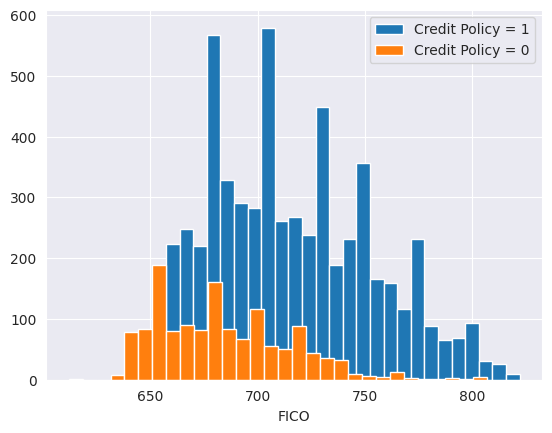

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style('darkgrid')
plt.hist(mydat['fico'].loc[mydat['credit_policy'] == 1], bins = 30, label = 'Credit Policy = 1')
plt.hist(mydat['fico'].loc[mydat['credit_policy'] == 0], bins = 30, label = 'Credit Policy = 0')
plt.legend()
plt.xlabel('FICO')

# 대출회사 기준 충족한 사람들이 신용도가 높은 곳에 분포할 확률이 큼

##### Purpose

In [39]:
print(X_train['purpose'].unique())
print(len(X_train['purpose'].unique()))

['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'educational' 'major_purchase']
7


In [40]:
mydat['purpose'].value_counts()

# debt_consolidation 항목이 대부분을 차지함. 즉, 채무를 상환하기 위해 신용대출 받는 사람이 많음

debt_consolidation    2949
all_other             1772
credit_card            945
home_improvement       483
small_business         458
major_purchase         336
educational            240
Name: purpose, dtype: int64

In [41]:
# 상환여부 별 purpose
mydat.groupby('not_fully_paid')['purpose'].value_counts()

not_fully_paid  purpose           
0               debt_consolidation    2492
                all_other             1488
                credit_card            836
                home_improvement       402
                small_business         329
                major_purchase         297
                educational            189
1               debt_consolidation     457
                all_other              284
                small_business         129
                credit_card            109
                home_improvement        81
                educational             51
                major_purchase          39
Name: purpose, dtype: int64

In [42]:
# Pr( not_fully_paid=1 | purpose) : purpose 범주 별 중 상환하지 않은 사람
# 자영업 목적인 경우 상환률 가장 높음, 신용카드 때문일 경우 상환률 가장 낮으나 눈에 띄게 낮진 않음

mydat.groupby('purpose')['not_fully_paid'].value_counts(normalize=True).loc[:,1].sort_values()

purpose
credit_card           0.115344
major_purchase        0.116071
debt_consolidation    0.154968
all_other             0.160271
home_improvement      0.167702
educational           0.212500
small_business        0.281659
Name: not_fully_paid, dtype: float64

<Axes: xlabel='purpose', ylabel='count'>

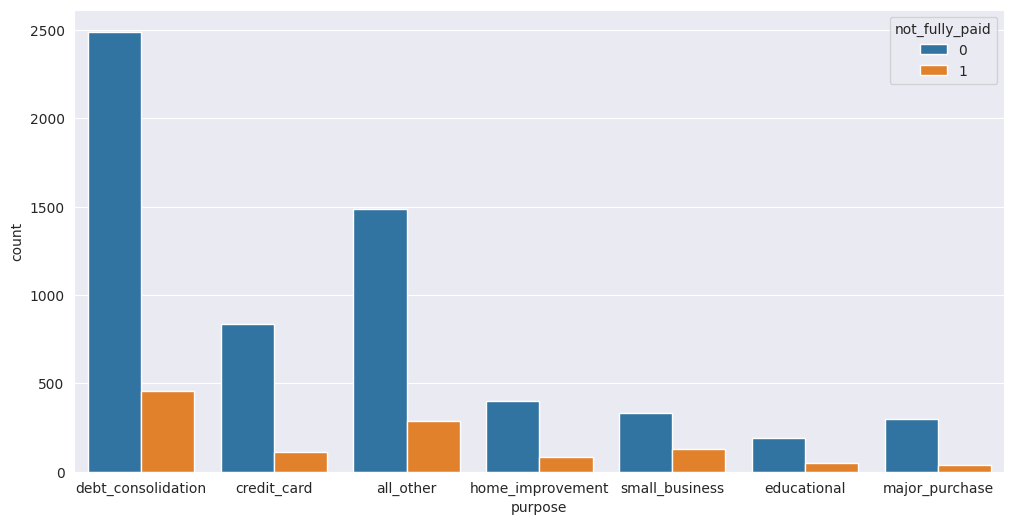

In [43]:
plt.figure(figsize = (12, 6))
sns.countplot(data = mydat, x = 'purpose', hue = 'not_fully_paid')

# debt_consolidation과 all other로 재분류 해볼 것

- 범주 합치고 인코딩 하기

(변환 전/후 넣어보고 더 성능 좋은 것으로 쓸 예정)

In [44]:
mydat['purpose_new'] = mydat['purpose'].replace(['credit_card', 'home_improvement', 'educational', 'small_business', 'major_purchase'], 'all_other', inplace = False)

In [45]:
mydat['purpose_new'].value_counts()

all_other             4234
debt_consolidation    2949
Name: purpose_new, dtype: int64

<Axes: xlabel='purpose_new', ylabel='count'>

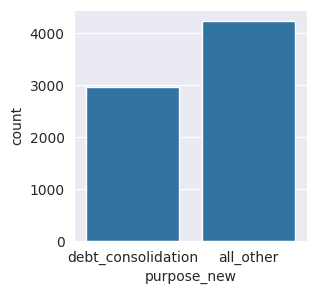

In [46]:
plt.figure(figsize = (3,3))
sns.countplot(x = 'purpose_new', data = mydat)

In [47]:
# test set에도 적용

X_test['purpose_new'] = X_test['purpose'].replace(['credit_card', 'home_improvement', 'educational', 'small_business', 'major_purchase'], 'all_other', inplace = False)

In [48]:
X_test['purpose_new'].value_counts()

all_other             1387
debt_consolidation    1008
Name: purpose_new, dtype: int64

In [49]:
# Label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# 변환 전
mydat['purpose'] = encoder.fit_transform(mydat['purpose'])
X_test['purpose'] = encoder.transform(X_test['purpose'])

In [50]:
# 체크
print(mydat['purpose'].head(5))
print('='*99)
print(mydat['purpose'].value_counts())
print('='*99)
print(X_test['purpose'].value_counts())

8714    2
1007    2
4502    2
3891    2
877     1
Name: purpose, dtype: int64
2    2949
0    1772
1     945
4     483
6     458
5     336
3     240
Name: purpose, dtype: int64
2    1008
0     559
1     317
6     161
4     146
3     103
5     101
Name: purpose, dtype: int64


In [51]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# 변환 후
mydat['purpose_new'] = encoder.fit_transform(mydat['purpose_new'])
X_test['purpose_new'] = encoder.transform(X_test['purpose_new'])

In [52]:
# 체크
print(mydat['purpose_new'].head(5))
print('='*99)
print(mydat['purpose_new'].value_counts())
print('='*99)
print(X_test['purpose_new'].value_counts())

8714    1
1007    1
4502    1
3891    1
877     0
Name: purpose_new, dtype: int64
0    4234
1    2949
Name: purpose_new, dtype: int64
0    1387
1    1008
Name: purpose_new, dtype: int64


In [53]:
# 백업 데이터 생성

X_dat_back = mydat
X_test_back = X_test

##### Int rate

대출금 이자율로, 상환이 힘들 것 같은 사람들은 이자율이 높게 측정됨

In [54]:
mydat['int_rate'].describe()

count    7183.000000
mean        0.122474
std         0.026795
min         0.060000
25%         0.103900
50%         0.122100
75%         0.140700
max         0.212100
Name: int_rate, dtype: float64

In [55]:
mydat.groupby('not_fully_paid')['int_rate'].describe()

# 큰 차이는 없어보임

count      mean       std     min     25%     50%     75%  \
not_fully_paid                                                               
0               6033.0  0.120673  0.026734  0.0600  0.0996  0.1218  0.1387   
1               1150.0  0.131924  0.025087  0.0705  0.1154  0.1316  0.1461   

                   max  
not_fully_paid          
0               0.2121  
1               0.2121

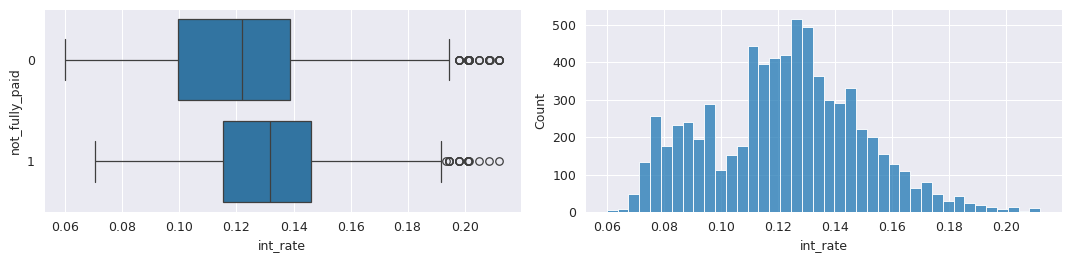

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'int_rate', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data=mydat.loc[mydat['int_rate'].notna(), 'int_rate'], kde=False, ax=ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# 상환하지 않은 그룹이 이자율이 더 높게 분포함
# 분포는 쌍봉우리 => 이자율이 낮은 그룹과 높은 그룹으로 분류 가능성. 하지만 연속형 변수로 넣는 게 좋으니 범주형 변환은 고려하지 않을 것임..
# 살짝 오른쪽 꼬리가 긺. => log 변환 고려

Text(0.5, 0, 'Int_rate')

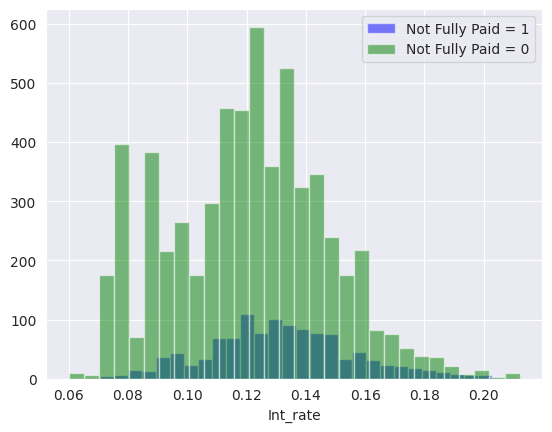

In [57]:
plt.hist(mydat['int_rate'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['int_rate'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('Int_rate')

# 상환한 그룹 중 이자율이 낮은 사람이 꽤 있어서 쌍봉우리 형태를 띄었던 것으로 판단됨.
# 아래 그래프를 더 참고해보았을 때 신용도 높음->이자율 낮음->상환 ok

<Figure size 1000x600 with 0 Axes>

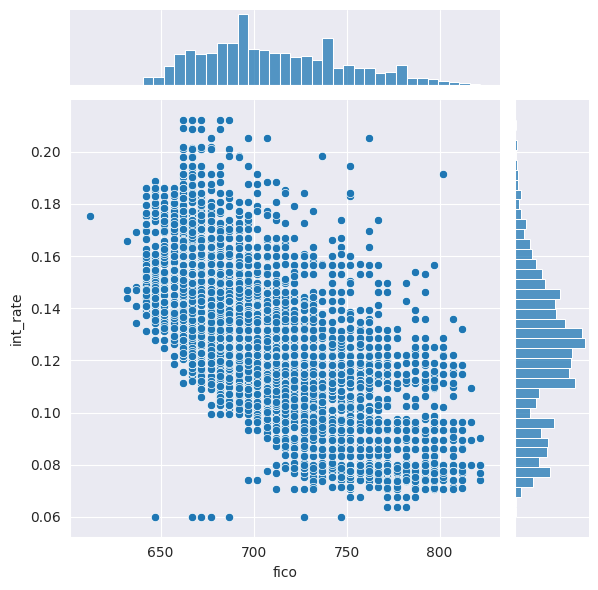

In [58]:
plt.figure(figsize = (10, 6))
sns.jointplot(x = 'fico', y = 'int_rate', data = mydat)

# 신용도가 높을수록 이자율이 낮은 것을 알 수 있음

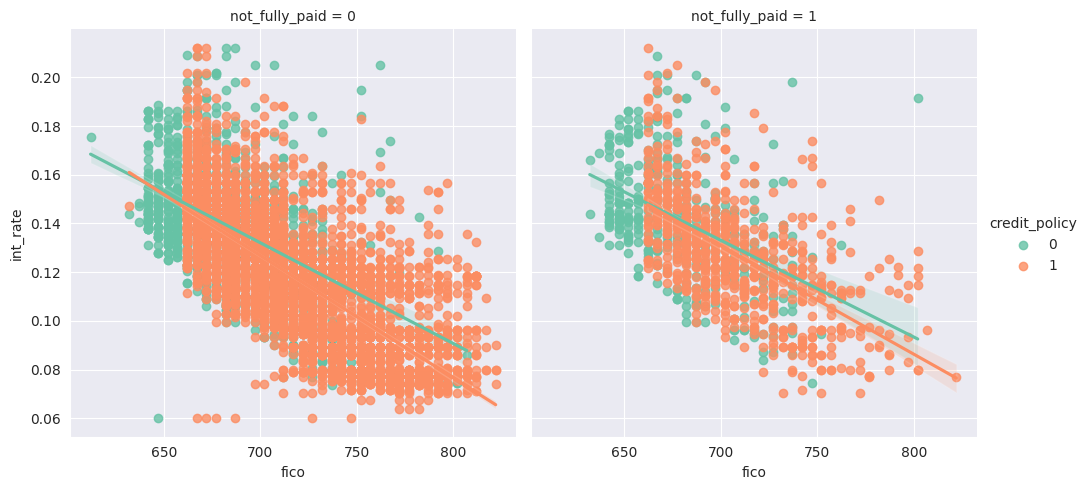

In [59]:
# lm(이자율 ~ 신용도) target 그룹 별 산점도와 회귀직선

sns.lmplot(data = mydat, x = 'fico', y = 'int_rate', hue = 'credit_policy', col = 'not_fully_paid', palette = 'Set2')

# 상환, 상환X 그룹 모두 음의 상관관계 있음. => 두 그룹 모두 신용도가 높을수록 이자율 낮음.

In [60]:
import numpy as np

mydat['int_rate_log'] = np.log1p(mydat['int_rate'])

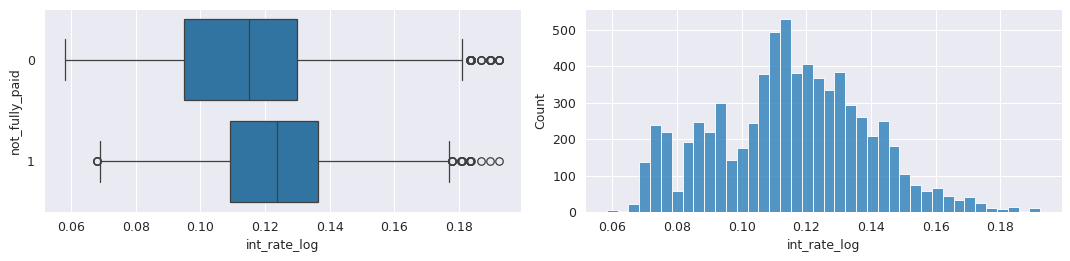

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'int_rate_log', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data=mydat.loc[mydat['int_rate_log'].notna(), 'int_rate_log'], kde=False, ax=ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

In [62]:
mydat['int_rate_log'].describe()

count    7183.000000
mean        0.115251
std         0.023841
min         0.058269
25%         0.098849
50%         0.115202
75%         0.131642
max         0.192354
Name: int_rate_log, dtype: float64

##### installment

월 상환 개월 수를 나타내는 변수

In [63]:
mydat['installment'].describe()

count    7183.000000
mean      317.796052
std       207.153118
min        15.670000
25%       162.010000
50%       267.290000
75%       432.945000
max       940.140000
Name: installment, dtype: float64

In [64]:
mydat.groupby('not_fully_paid')['installment'].describe()

# 상환 완료한 그룹이 평균적으로 $23 높음.

count        mean         std    min     25%      50%  \
not_fully_paid                                                           
0               6033.0  314.019334  203.299630  15.67  160.64  265.360   
1               1150.0  337.609043  225.356208  21.59  166.58  277.845   

                     75%     max  
not_fully_paid                    
0               424.9700  940.14  
1               485.5775  926.83

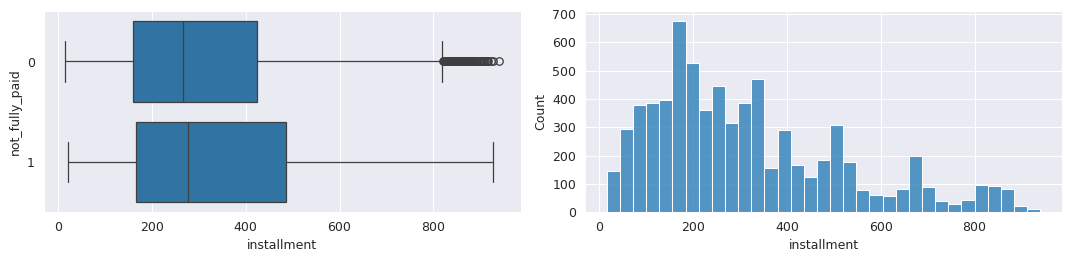

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'installment', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data=mydat.loc[mydat['installment'].notna(), 'installment'], kde=False, ax=ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# 상환여부에 따른 큰 차이는 없어보임 => 제외 가능성
# 상환한 그룹의 outlier 많음 => 상환은 다 했지만, 상환하기까지 기간이 오래 걸린 사람이 다수 존재함
# 분포는 오른쪽 꼬리가 긺 => 로그 변수 변환 고려

<Axes: xlabel='installment'>

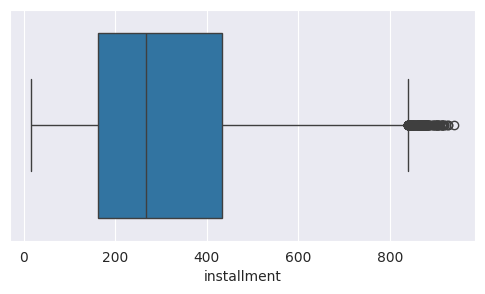

In [66]:
plt.figure(figsize = (6,3))
sns.boxplot(x = 'installment', data = mydat)

# outlier 조정 고려해볼 것

Text(0.5, 0, 'Installment')

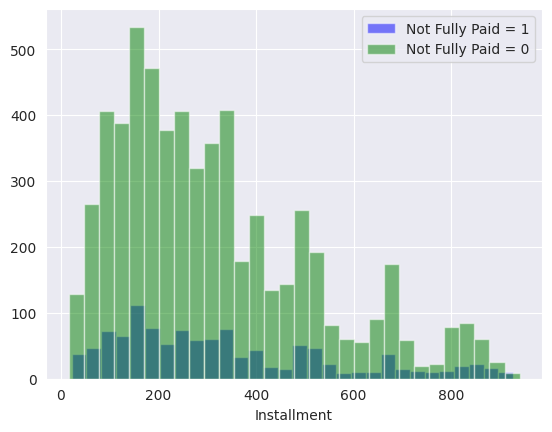

In [67]:
plt.hist(mydat['installment'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['installment'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('Installment')

# 상환여부 관계없이 두 그룹 모두 오른쪽 꼬리가 긺

<Figure size 1000x600 with 0 Axes>

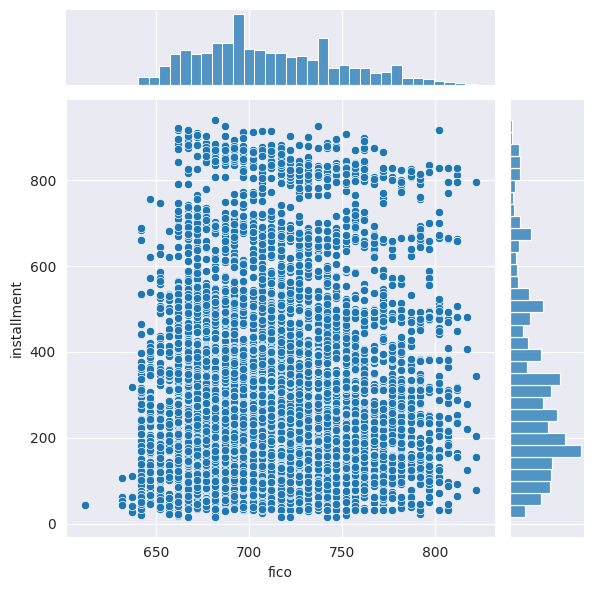

In [68]:
plt.figure(figsize = (10, 6))
sns.jointplot(x = 'fico', y = 'installment', data = mydat)

# 신용도와 상관관계 없어보임

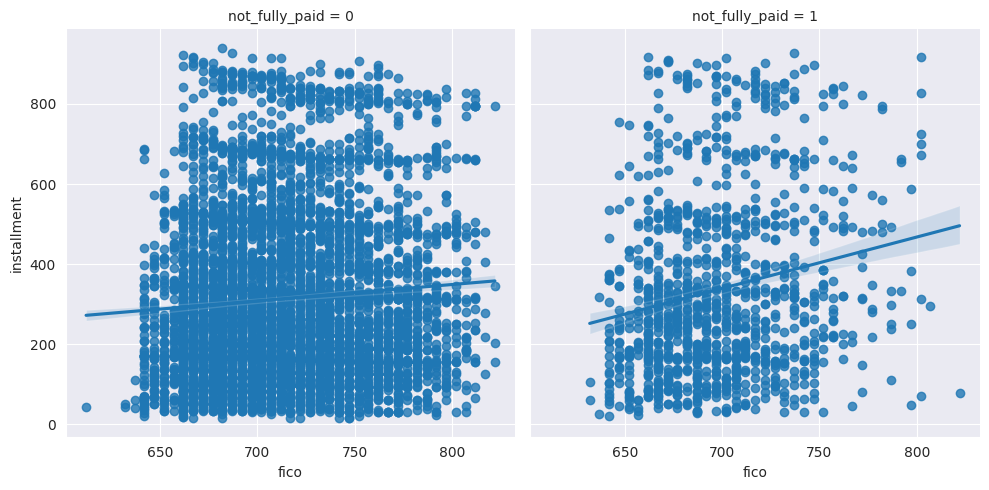

In [69]:
# lm(상환개월 ~ 신용도) target 그룹 별 산점도와 회귀직선

sns.lmplot(data = mydat, x = 'fico', y = 'installment', col = 'not_fully_paid', palette = 'Set1')

# 상환한 그룹은 아주 약한 양의 상관관계. 즉, 신용도와 할부금은 거의 관계가 없음.
# 상환X 그룹은 비교적 강한 양의 상관관계. 즉, 신용도가 높을수록 할부금도 큼.

In [70]:
mydat['installment_sqrt'] = np.sqrt(mydat['installment'])

mydat['installment_sqrt'].describe()

count    7183.000000
mean       16.878112
std         5.738465
min         3.958535
25%        12.728315
50%        16.349006
75%        20.807330
max        30.661702
Name: installment_sqrt, dtype: float64

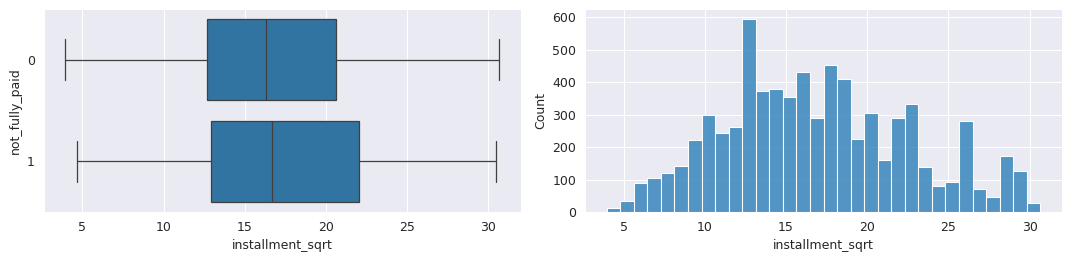

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'installment_sqrt', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data=mydat.loc[mydat['installment_sqrt'].notna(), 'installment_sqrt'], kde=False, ax=ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# Outlier 조정 됨

##### Annual income

In [72]:
mydat['log_annual_inc'].describe()

count    7183.000000
mean       10.928639
std         0.618944
min         7.547502
25%        10.545341
50%        10.915088
75%        11.302204
max        14.528354
Name: log_annual_inc, dtype: float64

In [73]:
mydat.groupby('not_fully_paid')['log_annual_inc'].describe()

count       mean       std       min        25%        50%  \
not_fully_paid                                                                
0               6033.0  10.937417  0.610675  7.547502  10.571317  10.933107   
1               1150.0  10.882589  0.659000  8.476371  10.491274  10.868568   

                      75%        max  
not_fully_paid                        
0               11.314475  14.528354  
1               11.277190  13.458836

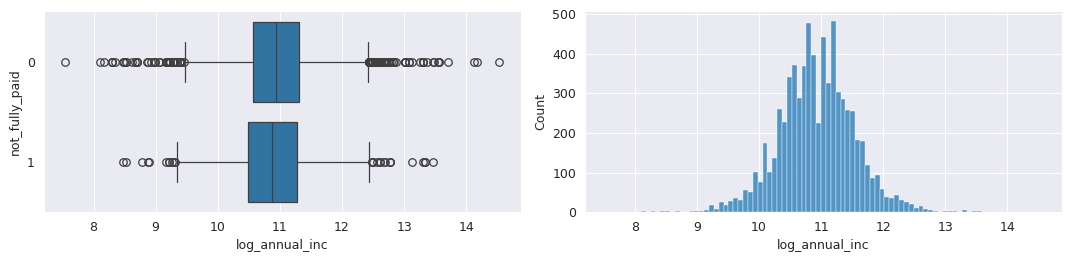

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'log_annual_inc', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['log_annual_inc'].notna(), 'log_annual_inc'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# Outlier가 꽤 많음 => 수입이 극도로 적거나 많은 집단 때문. => 의미있는 outlier라 판단하여 제거 X
# 1Q-1.5IQR, 3Q+1.5IQR로 변환

Text(0.5, 0, 'log_annual_inc')

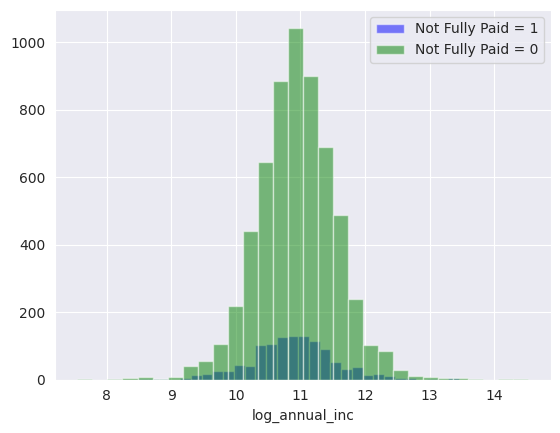

In [75]:
plt.hist(mydat['log_annual_inc'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['log_annual_inc'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('log_annual_inc')

# 첨도가 높은 정규분포의 형태를 띄어서 outlier가 많은 것으로 판단됨

<Figure size 1000x600 with 0 Axes>

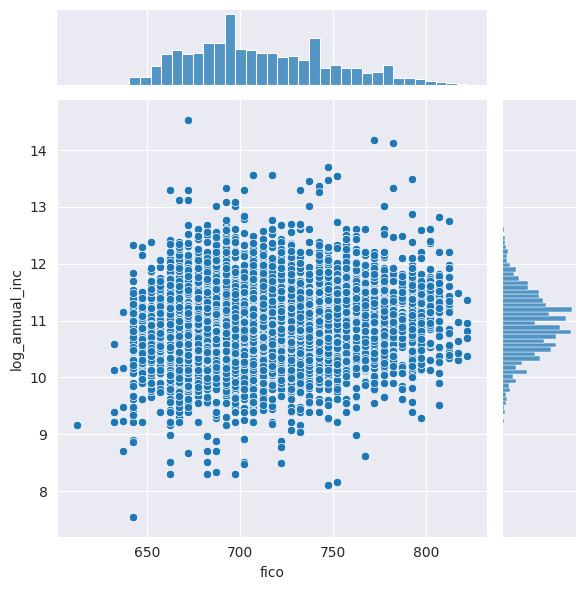

In [76]:
plt.figure(figsize = (10, 6))
sns.jointplot(x = 'fico', y = 'log_annual_inc', data = mydat)

# 신용도와 수입은 상관관계가 없어보임

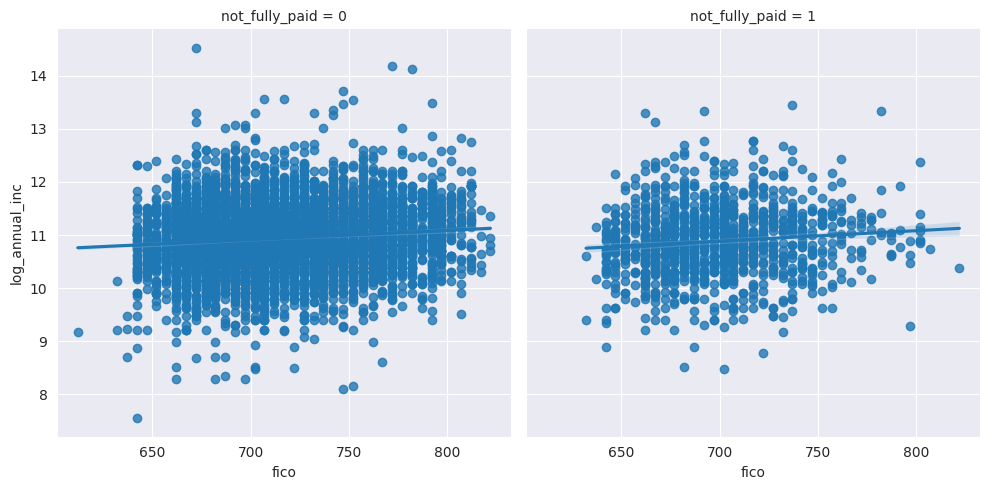

In [77]:
# lm(수입 ~ 신용도) + target

sns.lmplot(data = mydat, x = 'fico', y = 'log_annual_inc', col = 'not_fully_paid', palette = 'Set2')

##### dti

월 채무상환액/월 소득 비율

In [78]:
mydat['dti'].describe()

count    7183.000000
mean       12.576364
std         6.910338
min         0.000000
25%         7.150000
50%        12.630000
75%        17.940000
max        29.960000
Name: dti, dtype: float64

In [79]:
mydat.groupby('not_fully_paid')['dti'].describe()

count       mean       std  min    25%     50%    75%    max
not_fully_paid                                                               
0               6033.0  12.425904  6.866067  0.0  7.070  12.480  17.73  29.95
1               1150.0  13.365687  7.088982  0.0  7.835  13.475  19.15  29.96

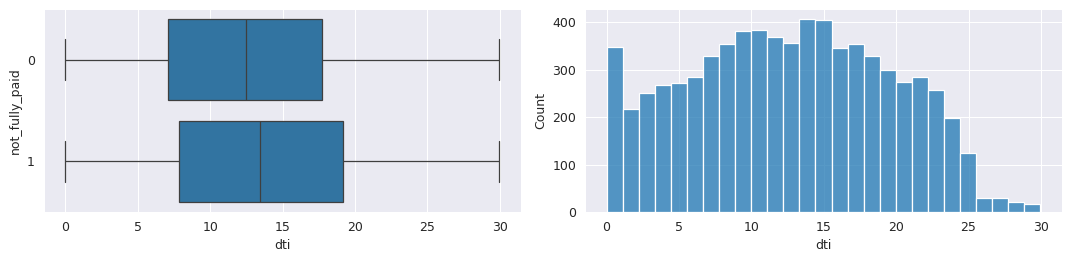

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'dti', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['dti'].notna(), 'dti'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# outlier도 없고 상환 여부에 관계없이 비율은 비슷해보임

Text(0.5, 0, 'DTI')

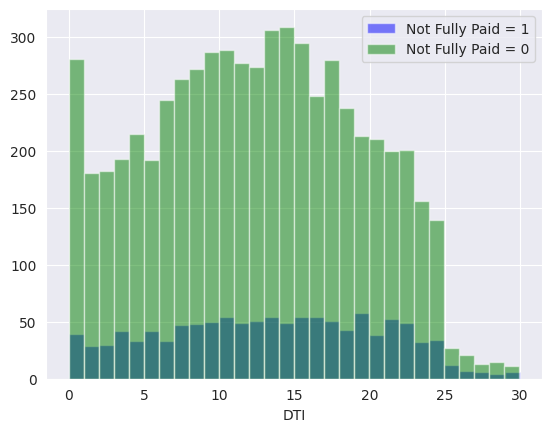

In [81]:
plt.hist(mydat['dti'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['dti'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('DTI')

# 역시나 상환 여부에 관계없이 분포 비슷해보임

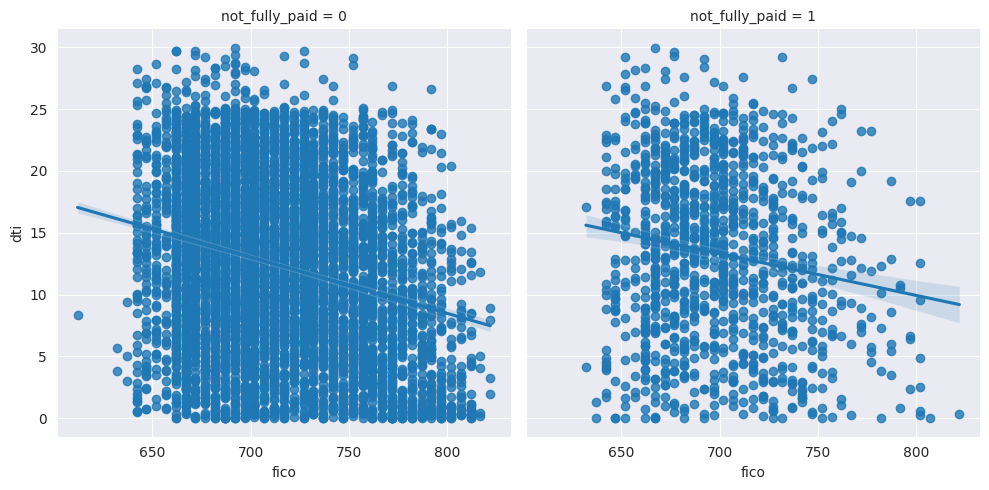

In [82]:
# lm(dti ~ 신용도) + target

sns.lmplot(data = mydat, x = 'fico', y = 'dti', col = 'not_fully_paid', palette = 'Set2')

# 상환 여부에 관계 없이 신용도가 높아지면 상환액/소득 비율이 낮아짐 => cuz 소득이 높으니까

##### fico

신용도

In [83]:
mydat['fico'].describe()

count    7183.000000
mean      711.105527
std        38.104869
min       612.000000
25%       682.000000
50%       707.000000
75%       737.000000
max       822.000000
Name: fico, dtype: float64

In [84]:
mydat.groupby('not_fully_paid')['fico'].describe()
# 큰 차이 없음

count        mean        std    min    25%    50%     75%  \
not_fully_paid                                                               
0               6033.0  713.513343  38.346617  612.0  682.0  707.0  742.00   
1               1150.0  698.473913  34.147924  632.0  672.0  697.0  720.75   

                  max  
not_fully_paid         
0               822.0  
1               822.0

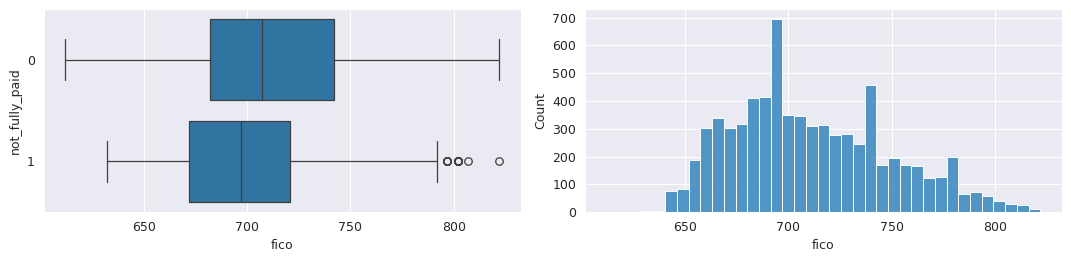

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'fico', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['fico'].notna(), 'fico'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# outlier 4개 존재, 상환한 그룹의 신용도가 높은 편
# 오른쪽 꼬리가 긺 => 로그 변환 => 해도 별 차이 없음

<Axes: xlabel='fico'>

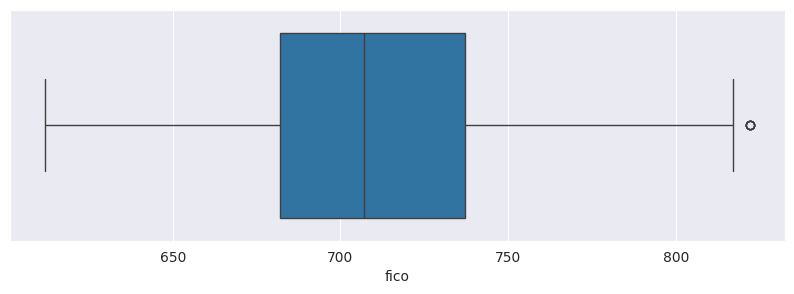

In [86]:
plt.figure(figsize = (10, 3))
sns.boxplot(x = 'fico', data = mydat)

# 전체적으로 보면 outlier 하나 존재 => max값으로 바꿔도 될 듯.

Text(0.5, 0, 'FICO')

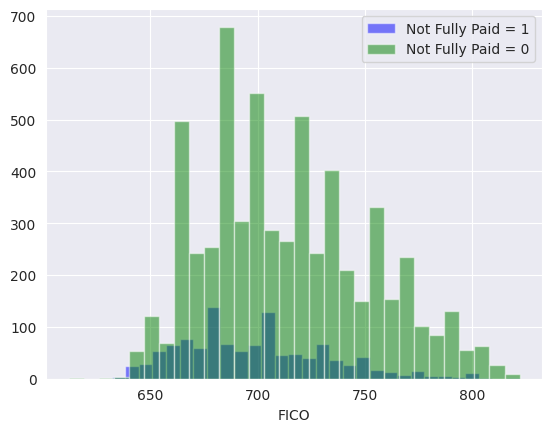

In [87]:
plt.hist(mydat['fico'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['fico'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('FICO')

# 상환하지 않은 집단의 신용도 분포가 조금 더 왼쪽

Text(0.5, 0, 'FICO')

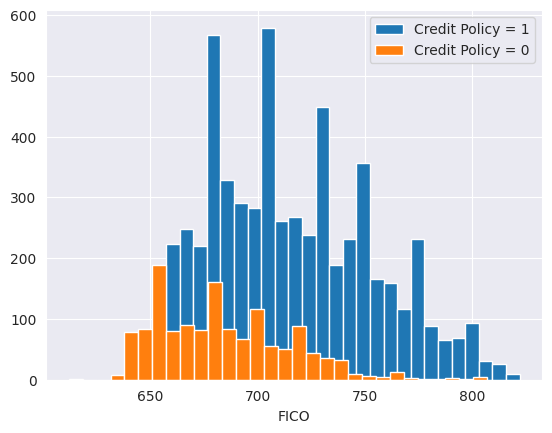

In [88]:
sns.set_style('darkgrid')

plt.hist(mydat['fico'].loc[mydat['credit_policy'] == 1], bins = 30, label = 'Credit Policy = 1')
plt.hist(mydat['fico'].loc[mydat['credit_policy'] == 0], bins = 30, label = 'Credit Policy = 0')
plt.legend()
plt.xlabel('FICO')

# 대출회사 기준 충족한 그룹의 신용도가 약간 더 오른쪽 => 신용도 높음

##### Dayswithcreditline

카드 유지 일 수

In [89]:
mydat['days_with_cr_line'].describe()

count     7183.000000
mean      4572.209244
std       2508.542108
min        178.958333
25%       2820.041667
50%       4140.000000
75%       5700.500000
max      17639.958330
Name: days_with_cr_line, dtype: float64

In [90]:
mydat.groupby('not_fully_paid')['days_with_cr_line'].describe()

count         mean          std         min          25%  \
not_fully_paid                                                              
0               6033.0  4595.918904  2513.101228  178.958333  2850.000000   
1               1150.0  4447.826304  2481.861008  180.041667  2730.010417   

                        50%          75%          max  
not_fully_paid                                         
0               4140.958333  5729.958333  17639.95833  
1               4080.000000  5610.000000  15692.00000

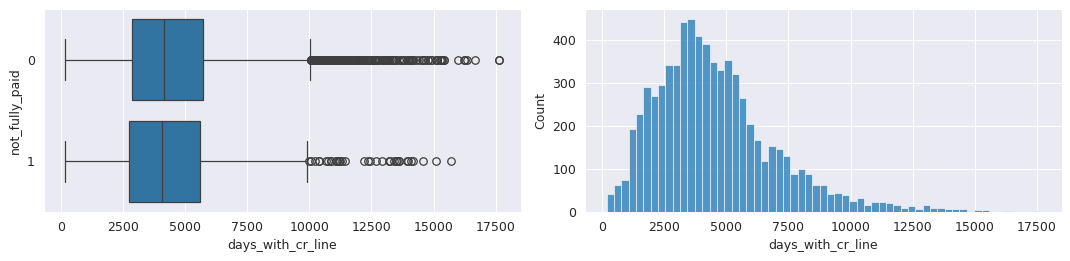

In [91]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'days_with_cr_line', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['days_with_cr_line'].notna(), 'days_with_cr_line'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()


# 두 그룹 모두 outlier 많음, 상환 여부 관계없이 신용카드를 길게 유지한 사람이 많음
# 오른쪽 꼬리가 긺 => 로그 변환, box-cox변환 고려

In [92]:
mydat['days_with_cr_line_sqrt'] = np.sqrt(mydat['days_with_cr_line'])

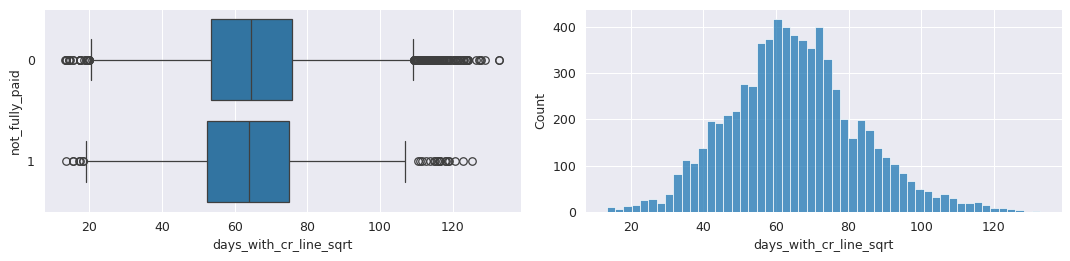

In [93]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'days_with_cr_line_sqrt', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['days_with_cr_line_sqrt'].notna(), 'days_with_cr_line_sqrt'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

# 변환 후에도 outlier 많음

<Axes: xlabel='days_with_cr_line_sqrt'>

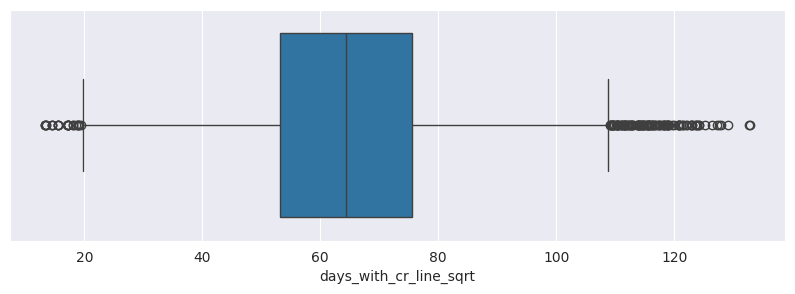

In [94]:
plt.figure(figsize = (10, 3))
sns.boxplot(x = 'days_with_cr_line_sqrt', data = mydat)

# outlier 조절 필요.

Text(0.5, 0, 'days_with_cr_line_sqrt')

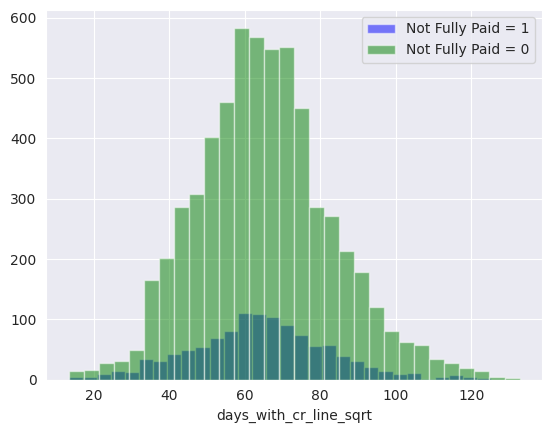

In [95]:
plt.hist(mydat['days_with_cr_line_sqrt'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['days_with_cr_line_sqrt'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('days_with_cr_line_sqrt')

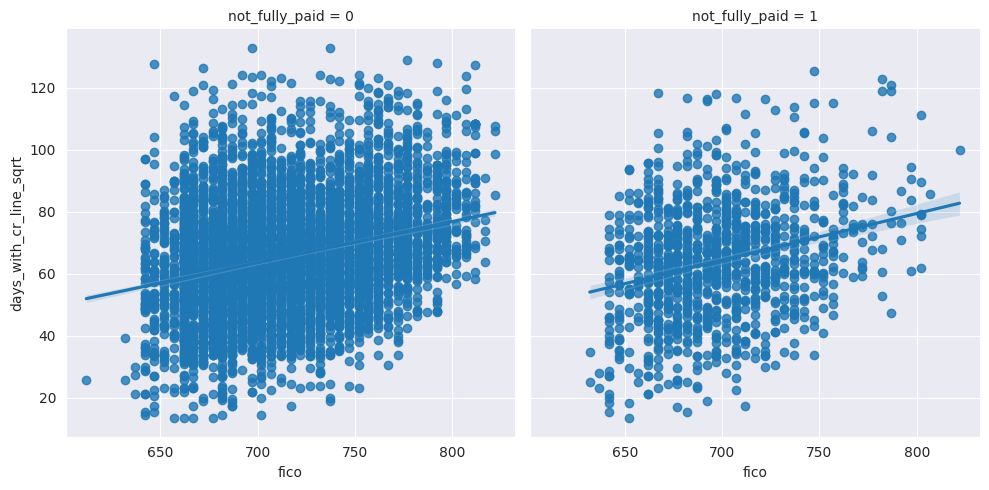

In [96]:
# lm(days_with_cr_line ~ 신용도) + target

sns.lmplot(data = mydat, x = 'fico', y = 'days_with_cr_line_sqrt', col = 'not_fully_paid', palette = 'Set2')

##### revol_bal

= balance: 신용대출 미지불 금액. 즉, 사용 금액 중 아직 카드 대금 내지 않은 상태

In [97]:
mydat['revol_bal'].describe()

count    7.183000e+03
mean     1.699933e+04
std      3.548478e+04
min      0.000000e+00
25%      3.131500e+03
50%      8.575000e+03
75%      1.812350e+04
max      1.207359e+06
Name: revol_bal, dtype: float64

In [98]:
mydat.groupby('not_fully_paid')['revol_bal'].describe()

# 상환하지 못한 그룹의 평균이 많이 높음

count          mean           std  min     25%     50%  \
not_fully_paid                                                            
0               6033.0  15989.619758  30283.547486  0.0  3118.0  8494.0   
1               1150.0  22296.333043  54978.700009  0.0  3324.0  8928.5   

                     75%        max  
not_fully_paid                       
0               17741.00   952013.0  
1               21026.25  1207359.0

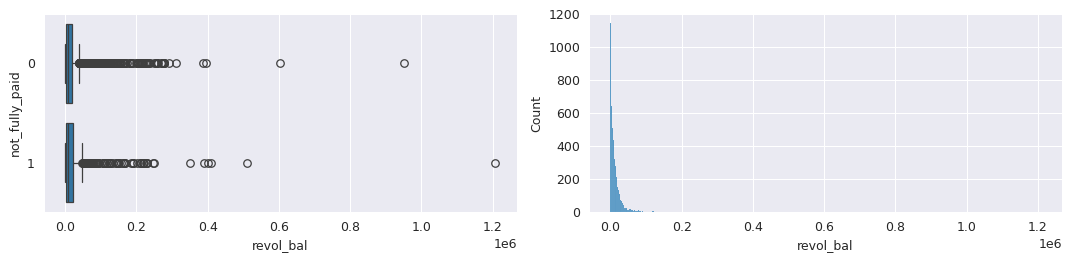

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'revol_bal', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['revol_bal'].notna(), 'revol_bal'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절


plt.show()

# 매우 큰 outlier 존재 => 3Q+1.5IQR로 변환 고려

<Axes: xlabel='revol_bal'>

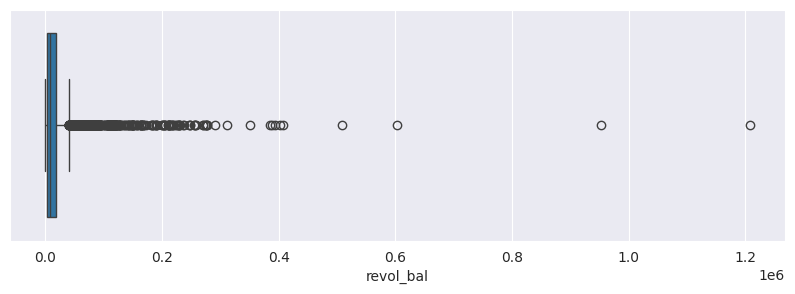

In [100]:
plt.figure(figsize = (10, 3))
sns.boxplot(x = 'revol_bal', data = mydat)

# outlier 조절 필요.

Text(0.5, 0, 'revol_bal')

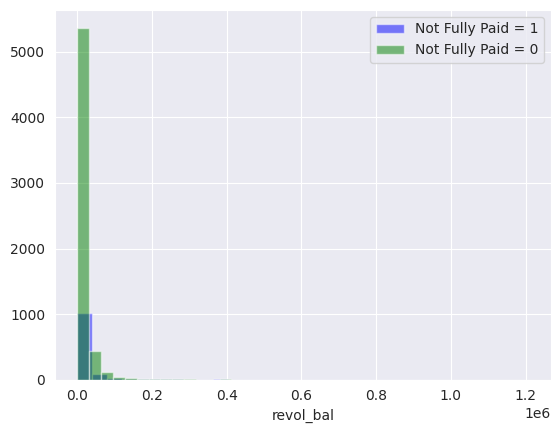

In [101]:
plt.hist(mydat['revol_bal'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['revol_bal'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('revol_bal')

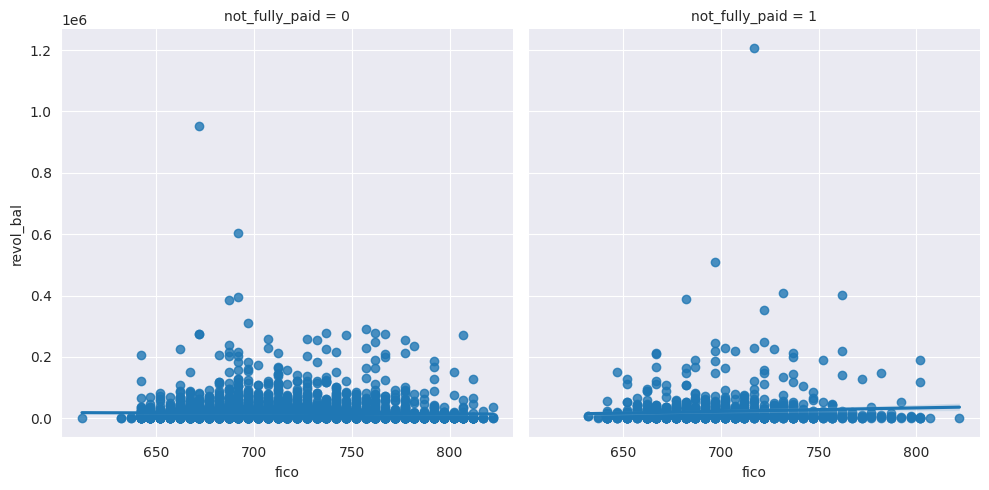

In [102]:
# lm(days_with_cr_line ~ 신용도) + target

sns.lmplot(data = mydat, x = 'fico', y = 'revol_bal', col = 'not_fully_paid', palette = 'Set2')

##### revol_util

신용카드 한도 대비 사용 비율 => if 한도가 천만원인데 남은 미지불 금액이 백만원이면 0.01

revol_bal/한도. 어차피 신용도 높으면 한도도 높을테니 다시 한도를 산출할 필요는 없을듯.

In [103]:
mydat['revol_util'].describe()

count    7183.000000
mean       46.539830
std        28.998644
min         0.000000
25%        22.200000
50%        45.700000
75%        70.900000
max       108.800000
Name: revol_util, dtype: float64

In [104]:
mydat.groupby('not_fully_paid')['revol_util'].describe()

# 상환하지 못한 그룹의 평균이 높음
# 상환하지 못한 그룹이 신용도도 낮고, 미지불금도 많으니 당연함.

count       mean        std  min    25%   50%     75%    max
not_fully_paid                                                               
0               6033.0  45.357732  28.865789  0.0  20.90  44.3  69.400  108.8
1               1150.0  52.741217  28.916840  0.0  30.95  54.4  77.475  103.5

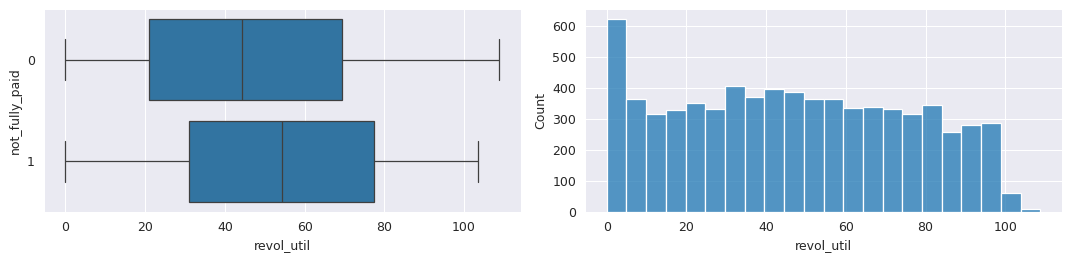

In [105]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3), dpi = 90)

sns.boxplot(x = 'revol_util', y = (mydat['not_fully_paid'].astype('category')), data = mydat, ax = ax1)
sns.histplot(data = mydat.loc[mydat['revol_util'].notna(), 'revol_util'], kde = False, ax = ax2)

plt.tight_layout() # subplot 간 간격 조절

plt.show()

<Axes: xlabel='revol_util'>

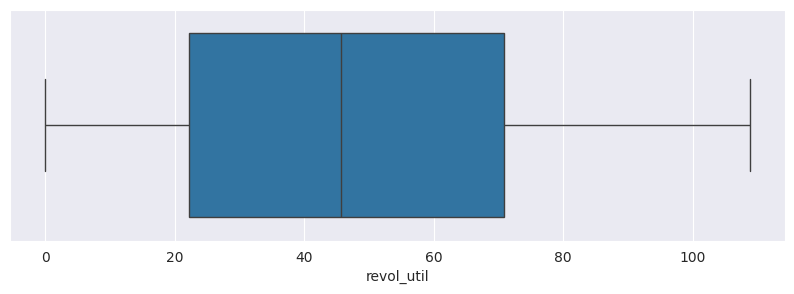

In [106]:
plt.figure(figsize = (10, 3))
sns.boxplot(x = 'revol_util', data = mydat)

Text(0.5, 0, 'revol_util')

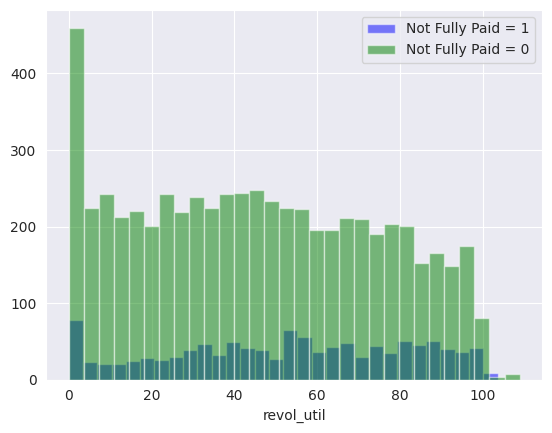

In [107]:
plt.hist(mydat['revol_util'].loc[mydat['not_fully_paid'] == 1], bins = 30, alpha = 0.5, color = 'blue', label = 'Not Fully Paid = 1')
plt.hist(mydat['revol_util'].loc[mydat['not_fully_paid'] == 0], bins = 30, alpha = 0.5, color = 'green', label = 'Not Fully Paid = 0')
plt.legend()
plt.xlabel('revol_util')

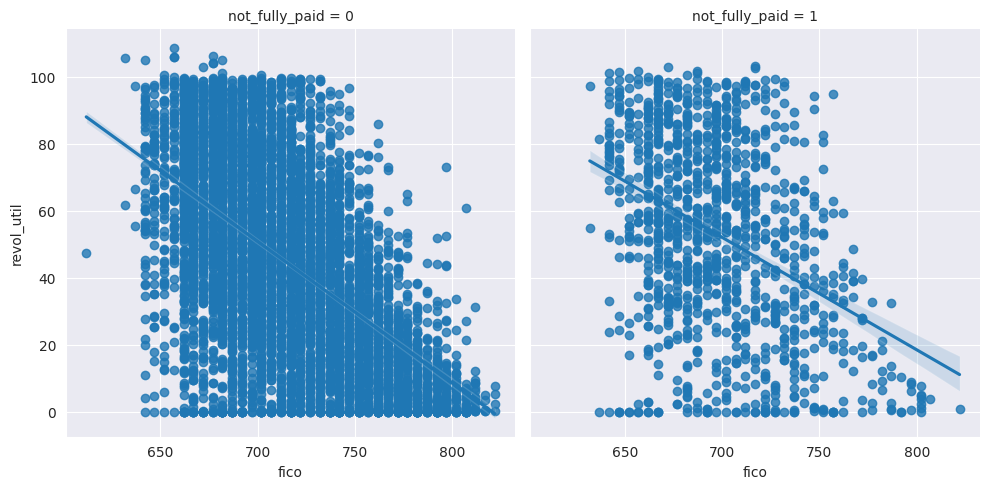

In [108]:
# lm(revol_util ~ 신용도) + target

sns.lmplot(data = mydat, x = 'fico', y = 'revol_util', col = 'not_fully_paid', palette = 'Set2')

# 신용도와 강한 음의 관계 => 신용도가 클수록 bal_util 낮음 => 즉, 신용도가 높을수록 한도가 높거나 전부 다 상환한 경우(bal_util = 0)가 많음

##### inq_last_6mths

wlsks 6개월 간 카드사에 문의를 남긴 수

In [109]:
mydat['inq_last_6mths'].unique()

array([ 2,  0,  8,  1,  4,  6,  3,  5, 18,  7,  9, 10, 12, 14, 15, 11, 13,
       33, 24, 31, 16, 32, 25, 27, 20])

<Axes: xlabel='inq_last_6mths', ylabel='count'>

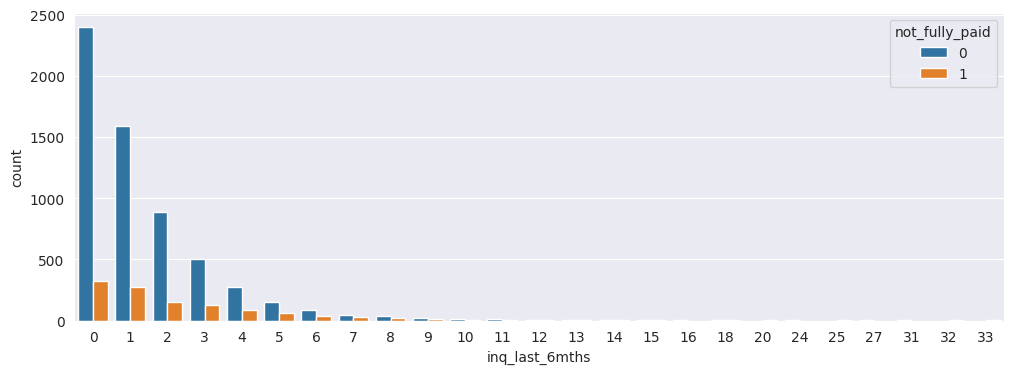

In [110]:
plt.figure(figsize = (12, 4))
sns.countplot(data = mydat, x = 'inq_last_6mths', hue = 'not_fully_paid')

# 있음/ 없음 binary로 재범주화 후 chi-square test하면 유의성 볼 수 있음

##### delinq_2yrs

지난 2년간 결제 기한이 30일 지난 수.

In [111]:
mydat['delinq_2yrs'].unique()

array([ 0,  1,  2,  3,  4,  5,  8, 13,  7, 11,  6])

<Axes: xlabel='delinq_2yrs', ylabel='count'>

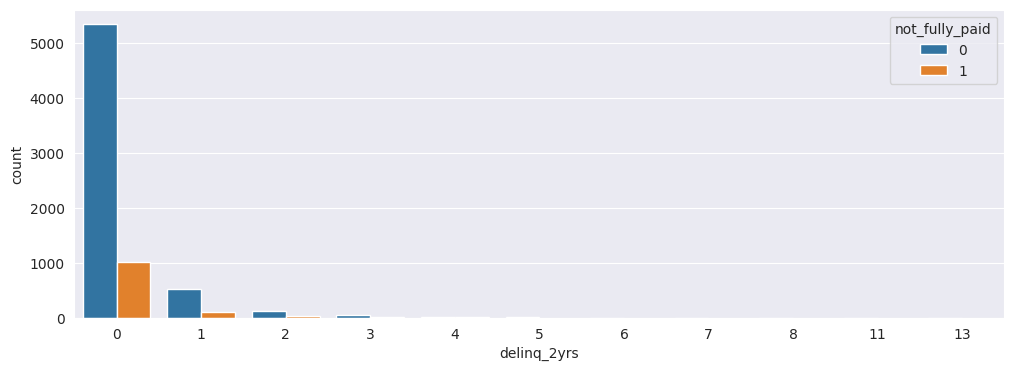

In [112]:
plt.figure(figsize = (12, 4))
sns.countplot(data = mydat, x = 'delinq_2yrs', hue = 'not_fully_paid')

# 있음/ 없음 binary로 재범주화 할 것

##### pub_rec

파산 신고 등 정부에 등록된 기록

In [113]:
mydat['pub_rec'].unique()

array([0, 2, 1, 4, 3])

<Axes: xlabel='pub_rec', ylabel='count'>

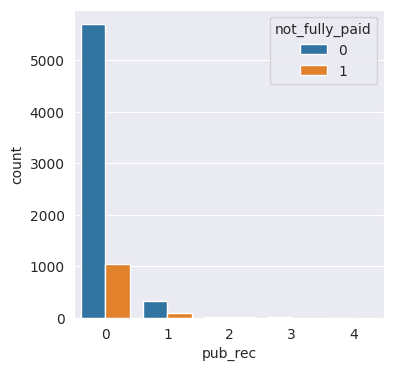

In [114]:
plt.figure(figsize = (4, 4))
sns.countplot(data = mydat, x = 'pub_rec', hue = 'not_fully_paid')

# 있음/ 없음 binary로 재범주화 할 것

In [115]:
# 백업 데이터 생성

X_train_back = X_train
X_test_back = X_test
Y_train_back = Y_train
mydat_back = mydat

#### Preprocessing

- **categorical variables**

In [116]:
# 범주형 변수 파생 변수 만들기

# 임계값 설정

threshold = 1

# 이분형 변수 생성

mydat['inq_last_6mths_new'] = (mydat['inq_last_6mths'] >= threshold).astype(int)
mydat['delinq_2yrs_new'] = (mydat['delinq_2yrs'] >= threshold).astype(int)
mydat['pub_rec_new'] = (mydat['pub_rec'] >= threshold).astype(int)

In [117]:
mydat[['inq_last_6mths_new', 'inq_last_6mths']].head()

inq_last_6mths_new  inq_last_6mths
8714                   1               2
1007                   0               0
4502                   0               0
3891                   0               0
877                    1               2

In [118]:
from scipy.stats import chi2_contingency

table = pd.crosstab(mydat['inq_last_6mths_new'], mydat['not_fully_paid'])

chi2_stat, p_val, df, expected = chi2_contingency(table)

print(table)
print()
print(p_val)
# 두 변수는 독립이 아님

not_fully_paid         0    1
inq_last_6mths_new           
0                   2396  320
1                   3637  830

3.2876783979183134e-14


In [119]:
table = pd.crosstab(mydat['delinq_2yrs_new'], mydat['not_fully_paid'])

chi2_stat, p_val, df, expected = chi2_contingency(table)

print(table)
print()
print(p_val)
# 두 변수는 독립 => 제외

not_fully_paid      0     1
delinq_2yrs_new            
0                5347  1011
1                 686   139

0.5172419565852694


In [120]:
table = pd.crosstab(mydat['pub_rec_new'], mydat['not_fully_paid'])

chi2_stat, p_val, df, expected = chi2_contingency(table)

print(table)
print()
print(p_val)
# 두 변수는 독립이 아님

not_fully_paid     0     1
pub_rec_new               
0               5697  1050
1                336   100

6.288316238735354e-05


In [121]:
# 백업 데이터 생성

X_train_back = X_train
X_test_back = X_test
Y_train_back = Y_train
mydat_back = mydat

- **continuous variables**

In [122]:
mydat.describe()

credit_policy      purpose     int_rate  installment  log_annual_inc  \
count    7183.000000  7183.000000  7183.000000  7183.000000     7183.000000   
mean        0.805791     1.938327     0.122474   317.796052       10.928639   
std         0.395618     1.690707     0.026795   207.153118        0.618944   
min         0.000000     0.000000     0.060000    15.670000        7.547502   
25%         1.000000     1.000000     0.103900   162.010000       10.545341   
50%         1.000000     2.000000     0.122100   267.290000       10.915088   
75%         1.000000     2.000000     0.140700   432.945000       11.302204   
max         1.000000     6.000000     0.212100   940.140000       14.528354   

               dti         fico  days_with_cr_line     revol_bal   revol_util  \
count  7183.000000  7183.000000        7183.000000  7.183000e+03  7183.000000   
mean     12.576364   711.105527        4572.209244  1.699933e+04    46.539830   
std       6.910338    38.104869        2508.542108  3.548478e+04    28.998644   
min       0.000000   612.000000         178.958333  0.000000e+00     0.000000   
25%       7.150000   682.000000        2820.041667  3.131500e+03    22.200000   
50%      12.630000   707.000000        4140.000000  8.575000e+03    45.700000   
75%      17.940000   737.000000        5700.500000  1.812350e+04    70.900000   
max      29.960000   822.000000       17639.958330  1.207359e+06   108.800000   

       ...  delinq_2yrs      pub_rec  not_fully_paid  purpose_new  \
count  ...  7183.000000  7183.000000     7183.000000  7183.000000   
mean   ...     0.160657     0.063901        0.160100     0.410553   
std    ...     0.548485     0.261113        0.366725     0.491968   
min    ...     0.000000     0.000000        0.000000     0.000000   
25%    ...     0.000000     0.000000        0.000000     0.000000   
50%    ...     0.000000     0.000000        0.000000     0.000000   
75%    ...     0.000000     0.000000        0.000000     1.000000   
max    ...    13.000000     4.000000        1.000000     1.000000   

       int_rate_log  installment_sqrt  days_with_cr_line_sqrt  \
count   7183.000000       7183.000000             7183.000000   
mean       0.115251         16.878112               65.142805   
std        0.023841          5.738465               18.129256   
min        0.058269          3.958535               13.377531   
25%        0.098849         12.728315               53.104065   
50%        0.115202         16.349006               64.342832   
75%        0.131642         20.807330               75.501656   
max        0.192354         30.661702              132.815505   

       inq_last_6mths_new  delinq_2yrs_new  pub_rec_new  
count         7183.000000      7183.000000  7183.000000  
mean             0.621885         0.114855     0.060699  
std              0.484950         0.318868     0.238794  
min              0.000000         0.000000     0.000000  
25%              0.000000         0.000000     0.000000  
50%              1.000000         0.000000     0.000000  
75%              1.000000         0.000000     0.000000  
max              1.000000         1.000000     1.000000  

[8 rows x 21 columns]

In [123]:
# Q1-1.5IQR, Q3+1.5IQR을 outlier 기준점으로 정의

# Outlier 상한선, 하한선
mydat_desc = mydat.describe().iloc[[4, 6]].T # 1사분위, 3사분위
mydat_desc['IQR'] = mydat_desc['75%'] - mydat_desc['25%']
mydat_desc['under'] = mydat_desc['25%'] - (1.5 * mydat_desc['IQR']) # 하한선
mydat_desc['upper'] = mydat_desc['75%'] + (1.5 * mydat_desc['IQR']) # 상한선
mydat_desc

25%           75%           IQR         under  \
credit_policy              1.000000      1.000000      0.000000      1.000000   
purpose                    1.000000      2.000000      1.000000     -0.500000   
int_rate                   0.103900      0.140700      0.036800      0.048700   
installment              162.010000    432.945000    270.935000   -244.392500   
log_annual_inc            10.545341     11.302204      0.756863      9.410047   
dti                        7.150000     17.940000     10.790000     -9.035000   
fico                     682.000000    737.000000     55.000000    599.500000   
days_with_cr_line       2820.041667   5700.500000   2880.458333  -1500.645832   
revol_bal               3131.500000  18123.500000  14992.000000 -19356.500000   
revol_util                22.200000     70.900000     48.700000    -50.850000   
inq_last_6mths             0.000000      2.000000      2.000000     -3.000000   
delinq_2yrs                0.000000      0.000000      0.000000      0.000000   
pub_rec                    0.000000      0.000000      0.000000      0.000000   
not_fully_paid             0.000000      0.000000      0.000000      0.000000   
purpose_new                0.000000      1.000000      1.000000     -1.500000   
int_rate_log               0.098849      0.131642      0.032793      0.049660   
installment_sqrt          12.728315     20.807330      8.079016      0.609792   
days_with_cr_line_sqrt    53.104065     75.501656     22.397591     19.507678   
inq_last_6mths_new         0.000000      1.000000      1.000000     -1.500000   
delinq_2yrs_new            0.000000      0.000000      0.000000      0.000000   
pub_rec_new                0.000000      0.000000      0.000000      0.000000   

                               upper  
credit_policy               1.000000  
purpose                     3.500000  
int_rate                    0.195900  
installment               839.347500  
log_annual_inc             12.437499  
dti                        34.125000  
fico                      819.500000  
days_with_cr_line       10021.187499  
revol_bal               40611.500000  
revol_util                143.950000  
inq_last_6mths              5.000000  
delinq_2yrs                 0.000000  
pub_rec                     0.000000  
not_fully_paid              0.000000  
purpose_new                 2.500000  
int_rate_log                0.180831  
installment_sqrt           32.925854  
days_with_cr_line_sqrt    109.098042  
inq_last_6mths_new          2.500000  
delinq_2yrs_new             0.000000  
pub_rec_new                 0.000000

In [124]:
# int_rate
condition1 = mydat['int_rate_log'] > mydat_desc.loc['int_rate_log', 'upper']
mydat.loc[condition1, 'int_rate_log'] = mydat_desc.loc['int_rate_log', 'upper']

condition2 = mydat['int_rate_log'] < mydat_desc.loc['int_rate_log', 'under']
mydat.loc[condition2, 'int_rate_log'] = mydat_desc.loc['int_rate_log', 'under']

# log_annual_inc
condition1 = mydat['log_annual_inc'] > mydat_desc.loc['log_annual_inc', 'upper']
mydat.loc[condition1, 'log_annual_inc'] = mydat_desc.loc['log_annual_inc', 'upper']

condition2 = mydat['log_annual_inc'] < mydat_desc.loc['log_annual_inc', 'under']
mydat.loc[condition2, 'log_annual_inc'] = mydat_desc.loc['log_annual_inc', 'under']

# days_with_cr_line
condition1 = mydat['days_with_cr_line_sqrt'] > mydat_desc.loc['days_with_cr_line_sqrt', 'upper']
mydat.loc[condition1, 'days_with_cr_line_sqrt'] = mydat_desc.loc['days_with_cr_line_sqrt', 'upper']

condition2 = mydat['days_with_cr_line_sqrt'] < mydat_desc.loc['days_with_cr_line_sqrt', 'under']
mydat.loc[condition2, 'days_with_cr_line_sqrt'] = mydat_desc.loc['days_with_cr_line_sqrt', 'under']

# revol_bal
condition1 = mydat['revol_bal'] > mydat_desc.loc['revol_bal', 'upper']
mydat.loc[condition1, 'revol_bal'] = mydat_desc.loc['revol_bal', 'upper']

condition2 = mydat['revol_bal'] < mydat_desc.loc['revol_bal', 'under']
mydat.loc[condition2, 'revol_bal'] = mydat_desc.loc['revol_bal', 'under']

In [125]:
mydat.describe()

credit_policy      purpose     int_rate  installment  log_annual_inc  \
count    7183.000000  7183.000000  7183.000000  7183.000000     7183.000000   
mean        0.805791     1.938327     0.122474   317.796052       10.927923   
std         0.395618     1.690707     0.026795   207.153118        0.590690   
min         0.000000     0.000000     0.060000    15.670000        9.410047   
25%         1.000000     1.000000     0.103900   162.010000       10.545341   
50%         1.000000     2.000000     0.122100   267.290000       10.915088   
75%         1.000000     2.000000     0.140700   432.945000       11.302204   
max         1.000000     6.000000     0.212100   940.140000       12.437499   

               dti         fico  days_with_cr_line     revol_bal   revol_util  \
count  7183.000000  7183.000000        7183.000000   7183.000000  7183.000000   
mean     12.576364   711.105527        4572.209244  12623.311569    46.539830   
std       6.910338    38.104869        2508.542108  12213.992435    28.998644   
min       0.000000   612.000000         178.958333      0.000000     0.000000   
25%       7.150000   682.000000        2820.041667   3131.500000    22.200000   
50%      12.630000   707.000000        4140.000000   8575.000000    45.700000   
75%      17.940000   737.000000        5700.500000  18123.500000    70.900000   
max      29.960000   822.000000       17639.958330  40611.500000   108.800000   

       ...  delinq_2yrs      pub_rec  not_fully_paid  purpose_new  \
count  ...  7183.000000  7183.000000     7183.000000  7183.000000   
mean   ...     0.160657     0.063901        0.160100     0.410553   
std    ...     0.548485     0.261113        0.366725     0.491968   
min    ...     0.000000     0.000000        0.000000     0.000000   
25%    ...     0.000000     0.000000        0.000000     0.000000   
50%    ...     0.000000     0.000000        0.000000     0.000000   
75%    ...     0.000000     0.000000        0.000000     1.000000   
max    ...    13.000000     4.000000        1.000000     1.000000   

       int_rate_log  installment_sqrt  days_with_cr_line_sqrt  \
count   7183.000000       7183.000000             7183.000000   
mean       0.115226         16.878112               65.033701   
std        0.023767          5.738465               17.765168   
min        0.058269          3.958535               19.507678   
25%        0.098849         12.728315               53.104065   
50%        0.115202         16.349006               64.342832   
75%        0.131642         20.807330               75.501656   
max        0.180831         30.661702              109.098042   

       inq_last_6mths_new  delinq_2yrs_new  pub_rec_new  
count         7183.000000      7183.000000  7183.000000  
mean             0.621885         0.114855     0.060699  
std              0.484950         0.318868     0.238794  
min              0.000000         0.000000     0.000000  
25%              0.000000         0.000000     0.000000  
50%              1.000000         0.000000     0.000000  
75%              1.000000         0.000000     0.000000  
max              1.000000         1.000000     1.000000  

[8 rows x 21 columns]

In [126]:
mydat = mydat.drop(['not_fully_paid'], axis = 1)
X_train = mydat

In [127]:
# 백업 데이터 생성

X_train_back = X_train
X_test_back = X_test
Y_train_back = Y_train
mydat_back = mydat

- **Test set preprocessing**

    - Train set에 맞추어 똑같이 변수 변환, 파생변수 생성
    - Outlier 똑같이 조정

In [128]:
import numpy as np

X_test['int_rate_log'] = np.log1p(X_test['int_rate'])

X_test['installment_sqrt'] = np.sqrt(X_test['installment'])

X_test['days_with_cr_line_sqrt'] = np.sqrt(X_test['days_with_cr_line'])

In [129]:
# 임계값

threshold = 1

# 이분형 파생 변수 생성

X_test['inq_last_6mths_new'] = (X_test['inq_last_6mths'] >= threshold).astype(int)
X_test['delinq_2yrs_new'] = (X_test['delinq_2yrs'] >= threshold).astype(int)
X_test['pub_rec_new'] = (X_test['pub_rec'] >= threshold).astype(int)

In [130]:
# Outlier adjustment

# int_rate
condition1 = X_test['int_rate_log'] > mydat_desc.loc['int_rate_log', 'upper'] # Outlier는 train data 값 사용
X_test.loc[condition1, 'int_rate_log'] = mydat_desc.loc['int_rate_log', 'upper']

condition2 = X_test['int_rate_log'] < mydat_desc.loc['int_rate_log', 'upper']
X_test.loc[condition2, 'int_rate_log'] = mydat_desc.loc['int_rate_log', 'upper']

# log_annual_inc
condition1 = X_test['log_annual_inc'] > mydat_desc.loc['log_annual_inc', 'upper']
X_test.loc[condition1, 'log_annual_inc'] = mydat_desc.loc['log_annual_inc', 'upper']

condition2 = X_test['log_annual_inc'] < mydat_desc.loc['log_annual_inc', 'under']
X_test.loc[condition2, 'log_annual_inc'] = mydat_desc.loc['log_annual_inc', 'under']

# days_with_cr_line
condition1 = X_test['days_with_cr_line_sqrt'] > mydat_desc.loc['days_with_cr_line_sqrt', 'upper']
X_test.loc[condition1, 'days_with_cr_line_sqrt'] = mydat_desc.loc['days_with_cr_line_sqrt', 'upper']

condition2 = X_test['days_with_cr_line_sqrt'] < mydat_desc.loc['days_with_cr_line_sqrt', 'under']
X_test.loc[condition2, 'days_with_cr_line_sqrt'] = mydat_desc.loc['days_with_cr_line_sqrt', 'under']

# revol_bal
condition1 = X_test['revol_bal'] > mydat_desc.loc['revol_bal', 'upper']
X_test.loc[condition1, 'revol_bal'] = mydat_desc.loc['revol_bal', 'upper']

condition2 = X_test['revol_bal'] < mydat_desc.loc['revol_bal', 'under']
X_test.loc[condition2, 'revol_bal'] = mydat_desc.loc['revol_bal', 'under']

- **Scailing**

In [131]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale, columns = X_train.columns)
X_test_scale = scaler.transform(X_test)
X_test_scale = pd.DataFrame(X_test_scale, columns = X_test.columns)

In [132]:
X_train_scale.describe()

credit_policy      purpose     int_rate  installment  log_annual_inc  \
count    7183.000000  7183.000000  7183.000000  7183.000000     7183.000000   
mean        0.805791     0.323054     0.410745     0.326810        0.501371   
std         0.395618     0.281785     0.176169     0.224078        0.195111   
min         0.000000     0.000000     0.000000     0.000000        0.000000   
25%         1.000000     0.166667     0.288626     0.158296        0.375000   
50%         1.000000     0.333333     0.408284     0.272178        0.497131   
75%         1.000000     0.333333     0.530572     0.451367        0.625000   
max         1.000000     1.000000     1.000000     1.000000        1.000000   

               dti         fico  days_with_cr_line    revol_bal   revol_util  \
count  7183.000000  7183.000000        7183.000000  7183.000000  7183.000000   
mean      0.419772     0.471931           0.251604     0.310831     0.427756   
std       0.230652     0.181452           0.143665     0.300752     0.266532   
min       0.000000     0.000000           0.000000     0.000000     0.000000   
25%       0.238652     0.333333           0.151256     0.077109     0.204044   
50%       0.421562     0.452381           0.226851     0.211147     0.420037   
75%       0.598798     0.595238           0.316221     0.446265     0.651654   
max       1.000000     1.000000           1.000000     1.000000     1.000000   

       inq_last_6mths  delinq_2yrs      pub_rec  purpose_new  int_rate_log  \
count     7183.000000  7183.000000  7183.000000  7183.000000   7183.000000   
mean         0.047684     0.012358     0.015975     0.410553      0.464718   
std          0.066423     0.042191     0.065278     0.491968      0.193921   
min          0.000000     0.000000     0.000000     0.000000      0.000000   
25%          0.000000     0.000000     0.000000     0.000000      0.331101   
50%          0.030303     0.000000     0.000000     0.000000      0.464523   
75%          0.060606     0.000000     0.000000     1.000000      0.598660   
max          1.000000     1.000000     1.000000     1.000000      1.000000   

       installment_sqrt  days_with_cr_line_sqrt  inq_last_6mths_new  \
count       7183.000000             7183.000000         7183.000000   
mean           0.483822                0.508158            0.621885   
std            0.214898                0.198293            0.484950   
min            0.000000                0.000000            0.000000   
25%            0.328417                0.375000            0.000000   
50%            0.464008                0.500446            1.000000   
75%            0.630966                0.625000            1.000000   
max            1.000000                1.000000            1.000000   

       delinq_2yrs_new  pub_rec_new  
count      7183.000000  7183.000000  
mean          0.114855     0.060699  
std           0.318868     0.238794  
min           0.000000     0.000000  
25%           0.000000     0.000000  
50%           0.000000     0.000000  
75%           0.000000     0.000000  
max           1.000000     1.000000

In [133]:
X_test_scale.describe()

credit_policy      purpose     int_rate  installment  log_annual_inc  \
count    2395.000000  2395.000000  2395.000000  2395.000000     2395.000000   
mean        0.802505     0.326862     0.415104     0.332405        0.506162   
std         0.398192     0.279265     0.177521     0.223718        0.188838   
min         0.000000     0.000000     0.000000     0.000260        0.000000   
25%         1.000000     0.166667     0.286654     0.164337        0.391943   
50%         1.000000     0.333333     0.418146     0.281426        0.512182   
75%         1.000000     0.333333     0.533202     0.450366        0.620897   
max         1.000000     1.000000     1.028271     0.974915        1.000000   

               dti         fico  days_with_cr_line    revol_bal   revol_util  \
count  2395.000000  2395.000000        2395.000000  2395.000000  2395.000000   
mean      0.423818     0.466995           0.248983     0.316134     0.437291   
std       0.227133     0.178866           0.140999     0.300433     0.267039   
min       0.000000     0.000000           0.000062     0.000000     0.000000   
25%       0.243491     0.333333           0.147820     0.082243     0.216912   
50%       0.425234     0.428571           0.225133     0.212083     0.442096   
75%       0.601802     0.595238           0.321347     0.456496     0.653033   
max       0.997997     1.023810           0.920914     1.000000     1.093750   

       inq_last_6mths  delinq_2yrs      pub_rec  purpose_new  int_rate_log  \
count     2395.000000  2395.000000  2395.000000  2395.000000        2395.0   
mean         0.048156     0.013297     0.014196     0.420877           1.0   
std          0.067435     0.041489     0.066281     0.493803           0.0   
min          0.000000     0.000000     0.000000     0.000000           1.0   
25%          0.000000     0.000000     0.000000     0.000000           1.0   
50%          0.030303     0.000000     0.000000     0.000000           1.0   
75%          0.060606     0.000000     0.000000     1.000000           1.0   
max          0.848485     0.461538     1.250000     1.000000           1.0   

       installment_sqrt  days_with_cr_line_sqrt  inq_last_6mths_new  \
count       2395.000000             2395.000000         2395.000000   
mean           0.489359                0.504701            0.615449   
std            0.215448                0.199805            0.486591   
min            0.001131                0.000000            0.000000   
25%            0.336564                0.368660            0.000000   
50%            0.473723                0.497839            1.000000   
75%            0.630133                0.631590            1.000000   
max            0.985750                1.000000            1.000000   

       delinq_2yrs_new  pub_rec_new  
count      2395.000000  2395.000000  
mean          0.123173     0.051357  
std           0.328705     0.220771  
min           0.000000     0.000000  
25%           0.000000     0.000000  
50%           0.000000     0.000000  
75%           0.000000     0.000000  
max           1.000000     1.000000

- **Correlation Maxtrix**

    - correlation 검토 통해 feature 간 관계와 다중공선성 확인

In [134]:
X_train_scale.corr()

credit_policy   purpose  int_rate  installment  \
credit_policy                1.000000  0.014564 -0.297700     0.057890   
purpose                      0.014564  1.000000  0.110488     0.153839   
int_rate                    -0.297700  0.110488  1.000000     0.274617   
installment                  0.057890  0.153839  0.274617     1.000000   
log_annual_inc               0.030457  0.091314  0.063808     0.462952   
dti                         -0.091826 -0.049446  0.226978     0.050327   
fico                         0.344812  0.064511 -0.713016     0.088250   
days_with_cr_line            0.094636  0.048274 -0.116083     0.190269   
revol_bal                   -0.067271  0.029772  0.144917     0.331183   
revol_util                  -0.101368 -0.066870  0.461384     0.078648   
inq_last_6mths              -0.534496  0.035696  0.207752    -0.010008   
delinq_2yrs                 -0.082701 -0.013338  0.161972    -0.010760   
pub_rec                     -0.045637  0.001674  0.098523    -0.041907   
purpose_new                  0.022693  0.030445  0.121779     0.154509   
int_rate_log                -0.296478  0.108609  0.999594     0.274830   
installment_sqrt             0.070059  0.152128  0.265510     0.982744   
days_with_cr_line_sqrt       0.134933  0.049061 -0.125080     0.213323   
inq_last_6mths_new          -0.242013  0.046275  0.129230    -0.007991   
delinq_2yrs_new             -0.057149 -0.011136  0.177408    -0.003616   
pub_rec_new                 -0.044695 -0.000383  0.098124    -0.036748   

                        log_annual_inc       dti      fico  days_with_cr_line  \
credit_policy                 0.030457 -0.091826  0.344812           0.094636   
purpose                       0.091314 -0.049446  0.064511           0.048274   
int_rate                      0.063808  0.226978 -0.713016          -0.116083   
installment                   0.462952  0.050327  0.088250           0.190269   
log_annual_inc                1.000000 -0.045814  0.110340           0.347524   
dti                          -0.045814  1.000000 -0.244809           0.065297   
fico                          0.110340 -0.244809  1.000000           0.266876   
days_with_cr_line             0.347524  0.065297  0.266876           1.000000   
revol_bal                     0.464755  0.341709 -0.079065           0.297619   
revol_util                    0.061778  0.342620 -0.541899          -0.017920   
inq_last_6mths                0.029726  0.032336 -0.181523          -0.032277   
delinq_2yrs                   0.035283 -0.027529 -0.219834           0.064655   
pub_rec                       0.017988  0.005803 -0.151478           0.070601   
purpose_new                  -0.028658  0.171716 -0.154729          -0.015922   
int_rate_log                  0.062346  0.228802 -0.716900          -0.117878   
installment_sqrt              0.461785  0.056539  0.089288           0.187234   
days_with_cr_line_sqrt        0.394656  0.089151  0.281268           0.972891   
inq_last_6mths_new            0.025413  0.028804 -0.143309          -0.044408   
delinq_2yrs_new               0.032667 -0.013858 -0.234942           0.075119   
pub_rec_new                   0.015843  0.007622 -0.150726           0.076951   

                        revol_bal  revol_util  inq_last_6mths  delinq_2yrs  \
credit_policy           -0.067271   -0.101368       -0.534496    -0.082701   
purpose                  0.029772   -0.066870        0.035696    -0.013338   
int_rate                 0.144917    0.461384        0.207752     0.161972   
installment              0.331183    0.078648       -0.010008    -0.010760   
log_annual_inc           0.464755    0.061778        0.029726     0.035283   
dti                      0.341709    0.342620        0.032336    -0.027529   
fico                    -0.079065   -0.541899       -0.181523    -0.219834   
days_with_cr_line        0.297619   -0.017920       -0.032277     0.064655   
revol_bal                1.000000    0.422140        0.000426    

- Heatmap 통한 시각화
    - 다중공선성 없음

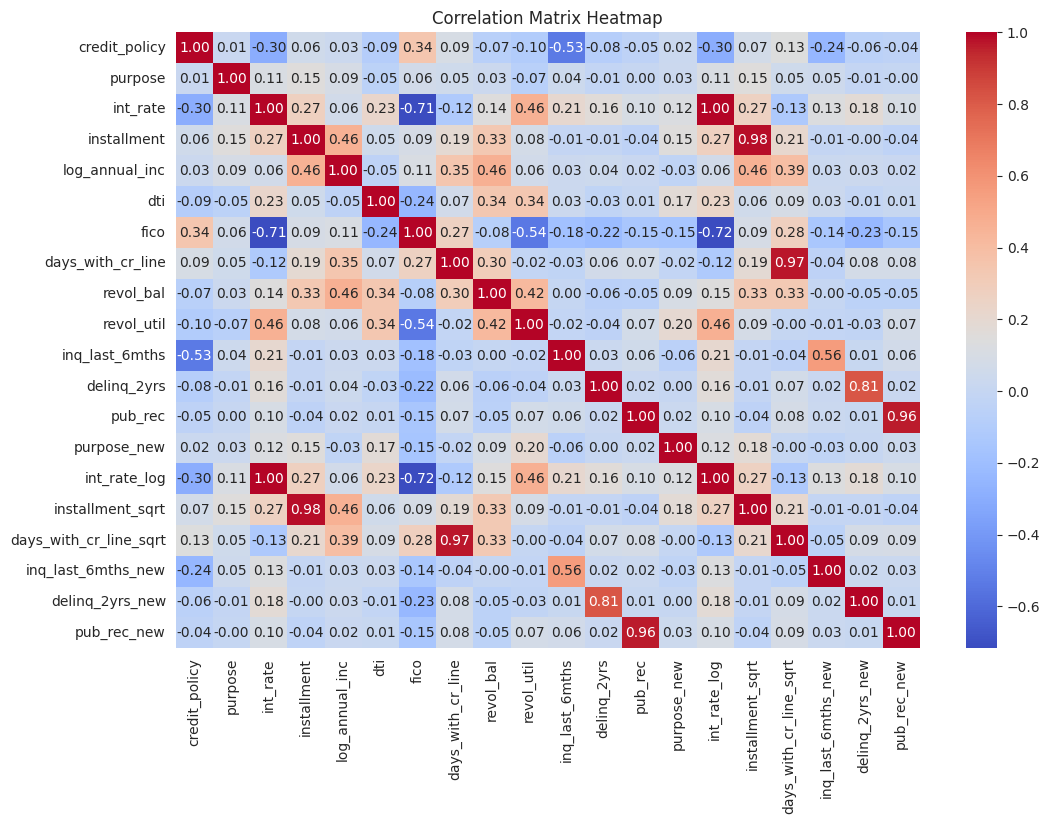

In [135]:
import seaborn as sns

corr_matrix = X_train_scale.corr()

# Heatmap 시각화
plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Matrix Heatmap')

plt. show()

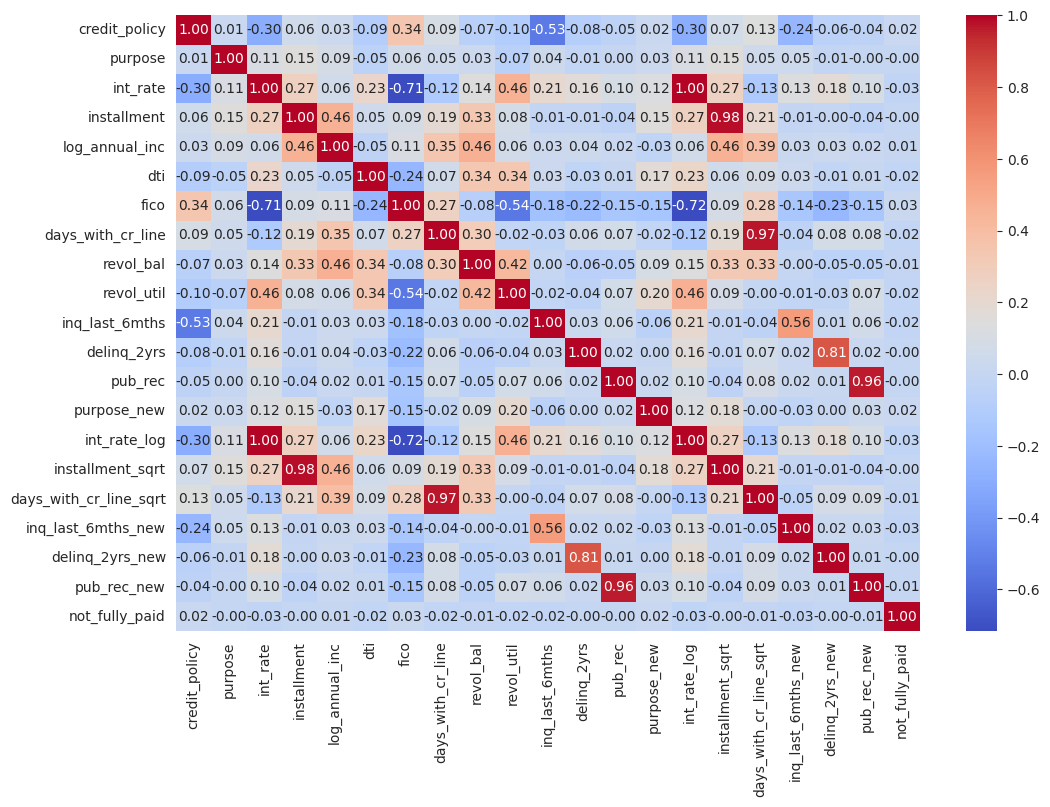

In [136]:
XX = pd.concat([X_train_scale, Y_train], axis = 1)

corr_XX = XX.corr()

import seaborn as sns

plt.figure(figsize = (12, 8))
sns.heatmap(corr_XX, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.show()

- 불필요한 변수 삭제

In [137]:
X_train_scale.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'purpose_new',
       'int_rate_log', 'installment_sqrt', 'days_with_cr_line_sqrt',
       'inq_last_6mths_new', 'delinq_2yrs_new', 'pub_rec_new'],
      dtype='object')

In [138]:
X_train_scale = X_train_scale.drop(['purpose', 'int_rate', 'installment', 'days_with_cr_line', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
                                   , axis = 1)

In [139]:
X_test_scale = X_test_scale.drop(['purpose', 'int_rate', 'installment', 'days_with_cr_line', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
                                   , axis = 1)

In [140]:
# 백업 데이터 생성

X_train_scale_back = X_train_scale
X_test_scale_back = X_test_scale
Y_train_back = Y_train
mydat_back = mydat

#### Target Variable

- target 변수인 대출금 상환 여부의 분포 => 불균형 데이터

- 0: 모두 상환, 1: 상환 X
- 약 6:1의 비율로 상환에 편향됨

**Imbalanced Data**


<해결 방안>

1. Oversampling
2. 머신러닝 모델 내부 파라미터 활용
3. Under sampling -> 정보를 버리는 것이기 때문에 효율적 X

In [141]:
Y_train.value_counts()

not_fully_paid
0                 6033
1                 1150
dtype: int64

##### SMOTE Oversampling

 - Training set을 train과 validation set으로 나눈 후 SMOTE 기법 적용
 - Target variable 범주의 비율:
    target=1의 비율을 줄일수록 TN 예측이 떨어지며, TP 예측이 올라감. 적절히 조절할 필요가 있음.

    정확도도 중요하지만, 대출을 상환할 것이라 예상했지만 상환하지 않은 그룹(FP)의 기회비용을 고려해야 함. 이 경우 금융 기관이 대출을 승인할 때 신용 위험이 높은 고객에게 대출을 제공하는 것이므로 손해가 발생할 수 있기 때문임.

In [142]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 56, sampling_strategy = 0.7)

x_train_sm, y_train_sm = smote.fit_resample(X_train_scale, Y_train)

In [143]:
print('oversampling training feature :', x_train_sm.shape, 'oversampling training target :', y_train_sm.shape)
print()
print('oversampling training target dist :\n', y_train_sm.value_counts())

oversampling training feature : (10256, 13) oversampling training target : (10256, 1)

oversampling training target dist :
 not_fully_paid
0                 6033
1                 4223
dtype: int64


In [144]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train_scale, Y_train, test_size = 0.3,
                                                  random_state = 56, stratify = Y_train)

In [145]:
# 백업 데이터 생성

x_train_sm_back = x_train_sm
x_val_back = x_val
X_test_scale_back = X_test_scale

## Modeling

**Feature Reconstruction**

- Over fitting 문제 완화를 위해 XGBoost의 feature importance 결과를 토대로 성능이 유지되거나 증가하면 제거

  -> revol_util, pub_rec_new, days_with_cr_line_sqrt, installment_sqrt, delinq_2yrs_new 삭제

- 선택된 변수들로 다시 train, validation, test set을 구성한 후 re-tuning함

In [146]:
x_train_sm = x_train_sm.drop(['revol_util', 'pub_rec_new', 'days_with_cr_line_sqrt', 'installment_sqrt', 'delinq_2yrs_new'], axis = 1)
x_val = x_val.drop(['revol_util', 'pub_rec_new', 'days_with_cr_line_sqrt', 'installment_sqrt', 'delinq_2yrs_new'], axis = 1)
X_test_scale = X_test_scale.drop(['revol_util', 'pub_rec_new', 'days_with_cr_line_sqrt', 'installment_sqrt', 'delinq_2yrs_new'], axis = 1)

In [147]:
x_train_sm.columns

Index(['credit_policy', 'log_annual_inc', 'dti', 'fico', 'revol_bal',
       'purpose_new', 'int_rate_log', 'inq_last_6mths_new'],
      dtype='object')

#### Imbalanced modeling 평가 지표

Imbalanced modeling은 양성과 음성 어느 것에 중점을 두어 예측할 지에 따라 평가 지표를 적절히 선택해야함. 모델의 성능은 Precision, Recall을 트래킹하고, 이를 조화평균한 F1 Score를 Metric으로 삼아 ROC Curve보다는 PR Curve로 성능을 평가함.

또한 imbalanced data set에서는 일반적으로 사용되는 평가 지표 보다는 라벨별 샘플 수의 비중에 따라 가중평균한 weighted score를 활용할 수 있음.
따라서 해당 모델에서는 weighted precision으로 트래킹하며, 모델 성능 평가 지표는 weighted f1-score를 사용할 것임.

**Over Sampling 했음에도 F1 score와 weighted F1 score가 다른 이유**

Balanced data에서 클래스 크기는 동일하지만, weighted F1은 각 클래스의 F1을 계산할 때 클래스별 샘플 수를 가중치로 사용함. 따라서 클래스의 크기가 동일하더라도 클래스 간의 오분류에 따라서 weighted F1이 변할 수 있기 때문이라고 생각됨.

예를 들어, 두 클래스가 500개의 샘플을 가지고 있는 균형 잡힌 데이터에서, 모델이 한 클래스를 다른 클래스로 오분류하는 경우가 발생하면, 이 오분류는 weighted F1에 영향을 줄 수 있음. 이 오분류가 발생한 클래스의 F1 점수가 감소하고, 다른 클래스의 F1 점수가 상승하여 weighted F1에 변화를 줄 수 있음.

그러나 향후 데이터 추가 수집 시 불균형해질 가능성이 있으며, validation, test는  imbalanced data임. 따라서 weighted F1 score를 사용하는 것이 모델 성능을 더 정확하게 평가하는 방법이라 생각됨.

**eval_metric = aucpr (Area Under PR Curve)**

  1. False Positive 비용 고려: FP는 대출을 상환할 것으로 예측했지만 실제로는 상환하지 않는 경우를 의미함(채무 불이행). 따라서 FP를 최소화하기 위해 Precision을 중점으로 보기 위함.

  2. 부정확한 대출 승인 방지 & 신용 위험 최소화: Recall이 낮으면 모델이 대출 상환을 할 수 있는 고객 식별에 실패할 수 있음. 이는 신용 위험이 높은 부적절한 대출 승인으로 이어질 수 있음. 따라서 Recall을 고려해야함.

  3. 고객 서비스 및 신뢰도: Precision이 높은 모델은 고객에게 신뢰감을 제공함. 금융 기관이 정확한 대출 상환 예측 모델을 사용하여 대출을 적절히 평가하고 승인하는 경우, 고객은 신뢰할 수 있는 금융 상품을 제공받게 됨.

#### Random Forest

1. default RF

    하이퍼 파라미터 튜닝 전 RF

In [148]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 56)

clf.fit(x_train_sm, y_train_sm)
y_val_pred_clf = clf.predict(x_val)

<ipython-input-148-42a669858eff>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_sm, y_train_sm)


In [150]:
y_test_pred = clf.predict(X_test_scale)

# Confusion matrix for RF on test data
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], y_test_pred)
print("Confusion Matrix:\n", conf_matrix)
print()

# Evaluate the performance on test data
print(classification_report(Y_test['not_fully_paid'], y_test_pred))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], y_test_pred, average='weighted'))

Confusion Matrix:
 [[1712  300]
 [ 278  105]]

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2012
           1       0.26      0.27      0.27       383

    accuracy                           0.76      2395
   macro avg       0.56      0.56      0.56      2395
weighted avg       0.76      0.76      0.76      2395

Weighted f1 score: 0.7613694456248875


Oversampling을 진행했음에도 정확도가 낮음.

우선 과적합을 방지하는 파라미터로 조금이나마 성능 개선을 해볼 것임.



---



2. Gridsearch 활용한 parameter tuning

In [153]:
start_time = time.time()

params = {
    'n_estimators' : [300, 1000],
    'max_depth' : [3, 4, 5],
    'min_samples_leaf' : [30, 40],
    'min_samples_split' : [30, 40]
}

rf = RandomForestClassifier(random_state = 56, n_jobs = -1)
rf_grid = GridSearchCV(rf, param_grid = params, scoring = 'f1_weighted', cv = 5, n_jobs = -1, verbose = 2)
rf_grid.fit(x_train_sm, y_train_sm)

# best f1 수치와 best parameter 확인
print("Best weighted f1 score : {0: .4f}".format(rf_grid.best_score_))
print("Best parameter : ", rf_grid.best_params_)

print("Running time: {0:.1f} sec ".format(time.time() - start_time))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best weighted f1 score :  0.6184
Best parameter :  {'max_depth': 5, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 300}
Running time: 382.4 sec 


In [154]:
# modeling with optimal hyperparameters
rf_best_params = rf_grid.best_params_
rf_best_model = RandomForestClassifier(**rf_best_params, random_state = 56)


rf_best_model.fit(x_train_sm, y_train_sm)

<ipython-input-154-2ada8988c8bb>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best_model.fit(x_train_sm, y_train_sm)


RandomForestClassifier(max_depth=5, min_samples_leaf=40, min_samples_split=30,
                       n_estimators=300, random_state=56)

In [155]:
# Confusion matrix and the performance for RF on train data

rf_train_pred = rf_best_model.predict(x_train_sm)
conf_matrix = confusion_matrix(y_train_sm, rf_train_pred)
print('='*15, 'Train Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_train_sm, rf_train_pred)) # weighted f1 =
print('Weighted f1 score:', f1_score(y_train_sm, rf_train_pred, average='weighted'))

# Confusion matrix and the performance for RF on validation data

rf_val_pred = rf_best_model.predict(x_val)
conf_matrix = confusion_matrix(y_val, rf_val_pred)
print('='*15, 'Validation Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_val, rf_val_pred)) # weighted f1 =
print('Weighted f1 score:', f1_score(y_val, rf_val_pred, average='weighted'))


# Confusion matrix and the performance for RF on test data

rf_test_pred = rf_best_model.predict(X_test_scale)
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], rf_test_pred)
print('='*15, 'Test Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(Y_test['not_fully_paid'], rf_test_pred)) # weighted f1 =
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], rf_test_pred, average='weighted'))

=============== Train Set ===============
Confusion Matrix:
 [[5221  812]
 [2773 1450]]

              precision    recall  f1-score   support

           0       0.65      0.87      0.74      6033
           1       0.64      0.34      0.45      4223

    accuracy                           0.65     10256
   macro avg       0.65      0.60      0.60     10256
weighted avg       0.65      0.65      0.62     10256

Weighted f1 score: 0.6220320237813246
=============== Validation Set ===============
Confusion Matrix:
 [[1587  223]
 [ 240  105]]

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1810
           1       0.32      0.30      0.31       345

    accuracy                           0.79      2155
   macro avg       0.59      0.59      0.59      2155
weighted avg       0.78      0.79      0.78      2155

Weighted f1 score: 0.7829393857343656
=============== Test Set ===============
Confusion Matrix:
 [[1714  298]
 [ 277  106]]


#### Extreme Gradient Boosting

1. default XGB

    하이퍼 파라미터 튜닝 전 XGB

In [148]:
xgb = XGBClassifier()

xgb.fit(x_train_sm, y_train_sm)
y_val_pred_xgb = xgb.predict(x_val)

In [153]:
# Confusion matrix for XGB on validation data
conf_matrix = confusion_matrix(y_val, y_val_pred_xgb)
print("Confusion Matrix:\n", conf_matrix)
print()

# Evaluate the performance on validation data
print(classification_report(y_val, y_val_pred_xgb))

Confusion Matrix:
 [[1788   22]
 [ 146  199]]

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1810
           1       0.90      0.58      0.70       345

    accuracy                           0.92      2155
   macro avg       0.91      0.78      0.83      2155
weighted avg       0.92      0.92      0.91      2155



In [154]:
y_test_pred_xgb = xgb.predict(X_test_scale)

# Confusion matrix for XGB on test data
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], y_test_pred_xgb)
print("Confusion Matrix:\n", conf_matrix)
print()

# Evaluate the performance on test data
print(classification_report(Y_test['not_fully_paid'], y_test_pred_xgb))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], y_test_pred_xgb, average='weighted'))

Confusion Matrix:
 [[1605  407]
 [ 311   72]]

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2012
           1       0.15      0.19      0.17       383

    accuracy                           0.70      2395
   macro avg       0.49      0.49      0.49      2395
weighted avg       0.73      0.70      0.71      2395

Weighted f1 score: 0.7132390429066878


정확도를 포기하더라도 과적합 문제 해결 필요함

또한 TP 예측을 거의 못 하는 것을 확인할 수 있음



---



2. Gridsearch 활용한 parameter tuning

**General Parameters**

- booster
  - 기본값 : gbtree
  - 어떤 부스터를 쓸지 고른다. [gbtree, gblinear, dart] 중 하나
- verbosity
  - 기본값 : 1
  - 출력 메시지 레벨
    [0 (silent), 1 (warning), 2 (info), 3 (debug)] 중 하나
- validate_parameters
  - 기본값 : false
  - 파라미터 유효성 검사
  - 설정. 여러 파라미터들을 설정하다 보면 서로 모순되는 값들을 넣는 실수를 방지해줌.
  - 아직 실험단계라 파이썬에선 지원 x
- nthread
  - 기본값 : 최대
  - 학습에 사용할 thread 수
- disable_default_eval_metric
  - 기본값 : 0
  - 0 이면 기본 metric 사용, 아니면 기본 metric을 사용하지 않음
    커스텀 metric을 사용할 경우 설정
- num_pbuffer
  - 기본값 : 자동으로 설정
  - 마지막 부스팅 단계의 예측 결과를 저장하는 버퍼의 크기
    자동으로 설정되기에 건드린 적 없음.
- num_feature
  - 기본값 : 인풋 피쳐의 수와 동일하게 설정됨
  - 부스팅에 사용되는 피쳐 수.
    자동으로 설정되기에 건드린 적 없음.

**Tree booster Parameter**

- eta [= learning_rate]

  - 기본값 : 0.3 / 범위 : [0,1]
  - 학습률. 낮은 값일수록 모델이 견고해지고 오버 피팅 방지에 좋다.
    일반적으로 0.01 ~ 0.3 정도로 설정
- gamma [= min_split_loss]

  - 기본값 : 0 / 범위 : [0,∞]
  
    gain 값이 gamma 이상일 경우 자식 노드를 생성하도록 한다.
  Overfitting 방지에 좋으나 너무 높으면 underfitting 이 생길 수가 있음.
  lambda, alpha 값에도 영향을 받기 때문에, 파라미터 튜닝 시 세 가지를 동시에 바꿔가며 grid search를 하는 편
- max_depth

  - 기본값 : 6 / 범위 : [0,∞]
    최대 트리의 깊이. N이라고 가정하면 2^N개의 리프 노드가 생긴다. 10일 때 최대 1024개의 리프 노트가 생김.

    일반적으로 Feature 수에 따라 3~6으로 세팅한 후 성능이 증가하고, 오버 피팅이 나지 않을 때까지 늘려감.

    제한된 리소스에 모델을 올려야 할 경우 울며 겨자 먹기로 약간의 성능을 포기하고 depth를 줄이기도 함.

- scale_pos_weight

  [default=1]

  데이터 클래스(레이블) 불균형이 있을 때 레이블 가중치를 조절해주는 파라미터

  권장 값 : sum(negative instances) / sum(positive instances)
  
  굉장히 중요한 파라미터. 데이터 불균형이 심한 경우 꼭 설정해주는 게 좋음.

**colsample_ 파라미터는 feature가 너무 많거나 소수의 feature에 지나치게 의존적일 때 사용하면 좋음.**

- colsample_bytree
  - 기본값 : 1 / 범위 : (0,1]
    각각의 트리(스탭)마다 사용할 칼럼(Feature)의 비율
    
    개인적으로 colsample_* 파라미터 둘 중에 가장 효과가 좋은 것 같음.
- colsample_bylevel
  - 기본값 : 1 / 범위 : (0,1]
  - 각각의 트리 depth 마다 사용할 칼럼(Feature)의 비율
- colsample_bynode
  - 기본값 : 1 / 범위 : (0,1]
  - 각각의 노드 depth 마다 사용할 칼럼(Feature)의 비율

    colsample_bylevel와 비슷해 보이지만 이 경우 좌, 우 리프 노드가 서로 다른 feature를 사용하게 됨.
- lambda [alias: reg_lambda]
  
  - 기본값 : 1 / 범위 : [0,∞]
  
  - L2 정규화(규제) 파라미터이다.

  - 커질수록 보수적인 모델을 생성하고 오버 피팅을 방지. 지나치게 클 경우 언더 피팅 발생.
  
    너무 큰 가중치를 그 크기에 비례하여 줄여줌
  
    noise나 outlier 등 너무 크게 튀는 데이터들을 어느 정도 잡아준다고 보면 됨.
  
    gamma, alpha와 함께 튜닝함.
- alpha [alias: reg_alpha]
  
  - 기본값 : 0 / 범위: [0,∞]

  - L1 정규화 파라미터.

  - 커질수록 보수적인 모델을 생성하고 오버 피팅을 방지.
  
    불필요한 가중치를 0으로 만들어서 무시하도록 함.
  
    sparse feature 가 있거나 feature수가 지나치게 많을 때 효과적.
  
    gamma, lambda와 함께 튜닝함.

**Learning Task Parameters**

학습 목표에 관련된 파라미터

- objective
  - 기본값 : reg:squarederror
  - 목적함수. 이 함수를 통해 나온 값이 최소화되는 방향으로 학습.
    
    - reg:squarederror / reg:squaredlogerror : 오차 제곱 / 오차 로그 제곱
    
    - binary:logistic : 이항 분류(binary class)에 사용. 대부분 이항 분류에서 이것만 사용.
    
    - multi:softmax / multi:softprob : 다항 분류(multi class)에 사용.
    
    - rank:pairwise / rank:ndcg / rank:map : l2r에 사용
- base_score
  - 기본값 : 0.5
    
    초기 편향치(bias).
  - 범위가 0~1 사이가 아닌 값을 예측하는 경우 이 값을 그 중간 값으로 설정해주면 가끔 성능이 좋아지거나 빨리 종료되기도 함.
- eval_metric
  - 기본값 : objective에 따라 다름.
  - 평가 지표이다. 각 스텝마다 완성된 모델을 이 지표를 통해서 평가.
    - rmse / rmsle : 글자 그대로 역순으로 해석하면 됨. 에러 (로그) 제곱 평균의 루트 값
    - mae : 오차 절댓값 평균
    - error / error@t : 이항 분류(binary class)에서 error는 0.5 이상을 1 미만을 0이라고 판단하고 error@t는 t 이상을 1 미만을 0이라고 판단.
    - merror : error의 다항 분류(multi class) 버전
    - auc : area under curve. FPR과 TPR에 민감한 데이터 셋 일 경우 사용.
    - aucpr : auc뒤에 붙은 pr은 preicison recall을 뜻함. f-score나 precision, recall에 민감할 때 사용.(error나 rmse가 더 잘 나오는 경우도 많으니 다 해봐야 함.)
- seed
  - 기본값 : 0


**ETC parameter**

- num_boost_round
  - 기본값 : 의무 설정 / 범위: [0,∞]
    
    몇 회의 step을 반복할지 지정. 너무 높은 값을 사용하면 오버 피팅이 생기고 모델의 사이즈가 커짐.
- early_stopping_rounds
  - 기본값 : 설정하지 않을 경우 비활성화. / 범위: [0,∞]
  - 조기 종료 조건.
    
    eval_metric이 결과가 early_stopping_rounds 횟수 동안 개선되지 않으면 num_boost_round에 도달하기 전에 종료.

In [ ]:
xgb_param_s = {
    'colsample_bytree': 0.3,
    'eval_metric': 'aucpr',
    'learning_rate': 0.015,
    'max_depth': 4,
    'n_estimators': 1000,
    'alpha' : 17,
    'gamma' : 15,
    'lambda' : 12,
    'objective': 'binary:logistic',
    'class_weight' : 'balanced'
}

In [206]:
xgb_param = {
    'n_estimators': [1000],
    'learning_rate': [0.05, 0.1, 0.13],
    'gamma': [10, 15],
    'objective': ['binary:logistic'],  # 이진 분류라 설정
    'eval_metric': ['aucpr'],  # precision, recall에 유의하여 판단해야 할 필요가 있음. 그러나 error나 rmse가 더 잘나오는 경우도 있어서 다 써봐야함
    'reg_lambda': [10, 15],  # L2 규제
    'alpha': [10, 15]  # L1 규제
}

In [207]:
start_time = time.time()


eval_set = [(x_val, y_val)] # early stopping 옵션에 넣을 validation set

xgb = XGBClassifier(random_state = 56)

xgb_grid = GridSearchCV(xgb, param_grid = xgb_param, scoring = 'f1_weighted', cv = 5, n_jobs = -1, verbose = 2)
xgb_grid.fit(x_train_sm, y_train_sm)


# best f1 수치와 best parameter 확인
print("Best weighted f1 score : {0: .4f}".format(xgb_grid.best_score_))
print("Best parameter : ", xgb_grid.best_params_)

# Best parameter fitting

xgb_best_model = XGBClassifier(**xgb_grid.best_params_, random_state = 56)

xgb_best_model.fit(x_train_sm, y_train_sm, eval_set = eval_set, early_stopping_rounds = 40)


print("Running time: {0:.1f} sec ".format(time.time() - start_time))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best weighted f1 score :  0.6831
Best parameter :  {'alpha': 10, 'eval_metric': 'aucpr', 'gamma': 10, 'learning_rate': 0.05, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_lambda': 10}
[0]	validation_0-aucpr:0.24331
[1]	validation_0-aucpr:0.24528
[2]	validation_0-aucpr:0.24297
[3]	validation_0-aucpr:0.24794
[4]	validation_0-aucpr:0.25038
[5]	validation_0-aucpr:0.24984
[6]	validation_0-aucpr:0.25133
[7]	validation_0-aucpr:0.25077
[8]	validation_0-aucpr:0.25232
[9]	validation_0-aucpr:0.25262
[10]	validation_0-aucpr:0.25204
[11]	validation_0-aucpr:0.25163
[12]	validation_0-aucpr:0.25244
[13]	validation_0-aucpr:0.25430
[14]	validation_0-aucpr:0.25514
[15]	validation_0-aucpr:0.25311
[16]	validation_0-aucpr:0.25484
[17]	validation_0-aucpr:0.25502
[18]	validation_0-aucpr:0.25316
[19]	validation_0-aucpr:0.25514
[20]	validation_0-aucpr:0.25499
[21]	validation_0-aucpr:0.25531
[22]	validation_0-aucpr:0.25534
[23]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-aucpr:0.26000
[38]	validation_0-aucpr:0.26929
[39]	validation_0-aucpr:0.27357
[40]	validation_0-aucpr:0.27312
[41]	validation_0-aucpr:0.27328
[42]	validation_0-aucpr:0.26397
[43]	validation_0-aucpr:0.26368
[44]	validation_0-aucpr:0.26662
[45]	validation_0-aucpr:0.26610
[46]	validation_0-aucpr:0.26614
[47]	validation_0-aucpr:0.26606
[48]	validation_0-aucpr:0.26588
[49]	validation_0-aucpr:0.26786
[50]	validation_0-aucpr:0.26798
[51]	validation_0-aucpr:0.26771
[52]	validation_0-aucpr:0.26775
[53]	validation_0-aucpr:0.26863
[54]	validation_0-aucpr:0.26900
[55]	validation_0-aucpr:0.26864
[56]	validation_0-aucpr:0.26832
[57]	validation_0-aucpr:0.26857
[58]	validation_0-aucpr:0.26857
[59]	validation_0-aucpr:0.26877
[60]	validation_0-aucpr:0.26877
[61]	validation_0-aucpr:0.26866
[62]	validation_0-aucpr:0.26878
[63]	validation_0-aucpr:0.26878
[64]	validation_0-aucpr:0.26878
[65]	validation_0-aucpr:0.26878
[66]	validation_0-aucpr:0.26878
[67]	validation_0-aucpr:0.26878
[68]	val

In [208]:
# Confusion matrix and the performance for XGB on train data

xgb_train_pred = xgb_best_model.predict(x_train_sm)
conf_matrix = confusion_matrix(y_train_sm, xgb_train_pred)
print('='*15, 'Train Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_train_sm, xgb_train_pred))
print('Weighted f1 score:', f1_score(y_train_sm, xgb_train_pred, average='weighted'))

# Confusion matrix and the performance for XGB on validation data

xgb_val_pred = xgb_best_model.predict(x_val)
conf_matrix = confusion_matrix(y_val, xgb_val_pred)
print('='*15, 'Validation Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_val, xgb_val_pred))
print('Weighted f1 score:', f1_score(y_val, xgb_val_pred, average='weighted'))


# Confusion matrix and the performance for XGB on test data

xgb_test_pred = xgb_best_model.predict(X_test_scale)
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], xgb_test_pred)
print('='*15, 'Test Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(Y_test['not_fully_paid'], xgb_test_pred))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], xgb_test_pred, average='weighted'))

=============== Train Set ===============
Confusion Matrix:
 [[5128  905]
 [2411 1812]]

              precision    recall  f1-score   support

           0       0.68      0.85      0.76      6033
           1       0.67      0.43      0.52      4223

    accuracy                           0.68     10256
   macro avg       0.67      0.64      0.64     10256
weighted avg       0.67      0.68      0.66     10256

Weighted f1 score: 0.6595346253480469
=============== Validation Set ===============
Confusion Matrix:
 [[1563  247]
 [ 235  110]]

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1810
           1       0.31      0.32      0.31       345

    accuracy                           0.78      2155
   macro avg       0.59      0.59      0.59      2155
weighted avg       0.78      0.78      0.78      2155

Weighted f1 score: 0.7778738310966254
=============== Test Set ===============
Confusion Matrix:
 [[1678  334]
 [ 267  116]]


In [209]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 행 전체 출력
pd.set_option('display.max_columns', None)  # 열 전체 출력

In [210]:
# Dataframe으로 parameter 랭킹 보기
result = pd.DataFrame(xgb_grid.cv_results_)
result.sort_values(by = ['rank_test_score'], inplace = True)

# result.columns

# table
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

params  mean_test_score  \
0   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.683118   
4   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.682187   
5   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.681325   
2   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.680638   
3   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.679101   
1   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.677663   
8   {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.659326   
10  {'alpha': 10, 'eval_metric': 'aucpr', 'gamma':...         0.656081   
16  {'alpha': 15, 'eval_metric': 'aucpr', 'gamma':...         0.655338   
12  {'alpha': 15, 'eval_metric': 'aucpr', 'gamma':...         0.654683   

    rank_test_score  
0                 1  
4                 2  
5                 3  
2                 4  
3                 5  
1                 6  
8                 7  
10                8  
16                9  
12               10

In [211]:
# 변수 중요도 확인
importances = xgb_best_model.feature_importances_

# 변수명과 중요도 묶어서 DF
feature_importance_df = pd.DataFrame({'Feature': x_train_sm.columns, 'Importance': importances})

# 중요도 높은 순으로 sort
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

print(feature_importance_df)

              Feature  Importance
0       credit_policy    0.382839
6        int_rate_log    0.221697
3                fico    0.122407
7  inq_last_6mths_new    0.060673
4           revol_bal    0.059334
1      log_annual_inc    0.057597
2                 dti    0.050389
5         purpose_new    0.045064


#### LightGBM

In [ ]:
lgb = LGBMClassifier(random_state = 56)

lgb.fit(x_train_sm, y_train_sm)
y_val_pred_lgb = lgb.predict(x_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6033, number of negative: 6033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 12066, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Confusion matrix for XGB on validation data
conf_matrix = confusion_matrix(y_val, y_val_pred_lgb)
print("Confusion Matrix:\n", conf_matrix)
print()

# Evaluate the performance on validation data
print(classification_report(y_val, y_val_pred_lgb))

Confusion Matrix:
 [[1771   39]
 [ 229  116]]

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1810
           1       0.75      0.34      0.46       345

    accuracy                           0.88      2155
   macro avg       0.82      0.66      0.70      2155
weighted avg       0.86      0.88      0.86      2155



In [ ]:
y_test_pred_lgb = lgb.predict(X_test_scale)

# Confusion matrix for XGB on test data
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], y_test_pred_lgb)
print("Confusion Matrix:\n", conf_matrix)
print()

# Evaluate the performance on test data
print(classification_report(Y_test['not_fully_paid'], y_test_pred_lgb))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], y_test_pred_lgb, average='weighted'))

Confusion Matrix:
 [[1913   99]
 [ 356   27]]

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2012
           1       0.21      0.07      0.11       383

    accuracy                           0.81      2395
   macro avg       0.53      0.51      0.50      2395
weighted avg       0.74      0.81      0.77      2395

Weighted f1 score: 0.7677620262284355


383개 중 TP only 27



---



2. Gridsearch 활용한 parameter tuning

**하이퍼 파라미터 튜닝 방안**


num_leaves를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하여 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

  - num_leaves: 각 트리의 최대 리프 수. 트리의 최대 깊이, 모형 성능, 학습속도에 영향을 미침. Maximum Depth와 함께 튜닝하는 것이 좋음. default = 31

  num_leaves 수를 높이면 정확도가 높아짐 ↔️ 트리 깊이 깊어지고 과적합 영향 커짐
보통 num_leaves = (2^depth-1)는 depth-wise tree와 같은 수의 leaves를 가지게 하여, 이보다 작게 설정해야 오버피팅을 줄일 수 있음.
예를 들어, max_depth가 7일 경우 좋은 성능을 보였다면, num_leaves는 128보다 적은 70~80사이에서 더 좋은 성능을 얻을 수 있음.
Maximum Depth 별로 여러 개의 Maximum Leaves의 조합을 만들어 cross validation 성능이 가장 좋은 조합을 찾아보는 것이 좋음.

- min_data_in_leaf: 사이킷런 래퍼 클래스에서 min_child_samples로 이름이 변경됨, 큰 값 설정시 트리가 깊어지는 것 방지 -> 과적합 방지

  큰 데이터(최소 10000건 이상)에서는 100~1000의 값이면 충분. default = 20

- max_depth: 명시적으로 깊이 제한. 위 두 파라미터와 결합하여 과적합 방지. max_depth를 찾을 때, 우선 큰 값으로 학습하면 default일 때와 metric이 같은 경우가 있음. 그 값을 찾은 이후에 gridsearch로 찾아서 적절한 max_depth를 찾으면 됨.

  경험상 LightGBM에서는 디폴트값이 가장 좋았음. (xgb의 경우 튜닝 필요했음)
  feature 약 280개, 데이터 약 10000건인 경우에는 약 20~30 사이 적절했음


- objective: 사용하는 데이터셋의 타겟팅 값의 형태에 따라 조정 필요

- metric: 성능 평가를 어떤 것으로 할 것인지 조정 필요
- colsample_bytree: 경험상 0.7 정도가 적당하며 세세히 튜닝할 필요는 없었음.

+) learning_rate을 작게, n_estimators를 크게 하는 부스팅 계열 튜닝 기본 방안을 적용하는 것도 좋음

+) 우선 xgb output을 참고하여 grid search를 시도할 예정

+) xgb와 random forest 모두 over fitting이 심했으므로 L1, L2 규제 등 일반화 성능 향상 시키는 방향으로 조정할 것

In [224]:
lgbm_param = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.13],
    'max_depth': [3, 6],
    'reg_lambda': [15, 10],  # L2 정규화
    'reg_alpha': [15, 10],  # L1 정규화
    'colsample_bytree': [0.5, 1],
    'objective': ['binary'],
    'class_weight' : ['balanced']
}

In [228]:
lgbm_param = {
    'n_estimators': [1000],
    'learning_rate': [0.001, 0.002],
    'max_depth': [3, 4],
    'reg_lambda': [15, 10],  # L2 정규화
    'reg_alpha': [15, 10],  # L1 정규화
    'colsample_bytree': [0.4, 0.5],
    'objective': ['binary'],
    'class_weight' : ['balanced'],
    'boosting' : ['dart']
}

In [229]:
start_time = time.time()

eval_set = [(x_val, y_val)] # early stopping 옵션에 넣을 validation set
# validation 셋을 활용해서 원하는 지점까지 학습 함.
# n_estimators=100으로 설정해서 10, 20, 30.. 가다가 40~50사이에 loss값이 증가해서 42지점에서 알아서 멈춤.
# 즉 validaion의 loss값이 최소가 될때 stop
# 이런식으로 하이퍼파라미터를 조정할 수도 있음.

lgbm = LGBMClassifier(eval_metric='auc', random_state = 56)

lgbm_grid = GridSearchCV(lgbm, param_grid = lgbm_param, scoring = 'f1_weighted', cv = 5, n_jobs = -1, verbose = 2)
lgbm_grid.fit(x_train_sm, y_train_sm)

# best f1 수치와 best parameter 확인

print("Best weighted f1 score : {0: .4f}".format(lgbm_grid.best_score_))
print("Best parameter : ", lgbm_grid.best_params_)


# Best parameter fitting

lgbm_best_model = LGBMClassifier(**lgbm_grid.best_params_, random_state = 56)

lgbm_best_model.fit(x_train_sm, y_train_sm, eval_set = eval_set, eval_metric='auc')

print("Running time: {0:.1f} sec ".format(time.time() - start_time))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 4223, number of negative: 6033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 10256, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [230]:
print("Best parameter : ", lgbm_grid.best_params_)

Best parameter :  {'boosting': 'dart', 'class_weight': 'balanced', 'colsample_bytree': 0.4, 'learning_rate': 0.002, 'max_depth': 4, 'n_estimators': 1000, 'objective': 'binary', 'reg_alpha': 10, 'reg_lambda': 10}


In [231]:
# Confusion matrix and the performance for LGBM on train data

lgbm_train_pred = lgbm_best_model.predict(x_train_sm)
conf_matrix = confusion_matrix(y_train_sm, lgbm_train_pred)
print('='*15, 'Train Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_train_sm, lgbm_train_pred))
print('Weighted f1 score:', f1_score(y_train_sm, lgbm_train_pred, average='weighted'))

# Confusion matrix and the performance for LGBM on validation data

lgbm_val_pred = lgbm_best_model.predict(x_val)
conf_matrix = confusion_matrix(y_val, lgbm_val_pred)
print('='*15, 'Validation Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_val, lgbm_val_pred))
print('Weighted f1 score:', f1_score(y_val, lgbm_val_pred, average='weighted'))


# Confusion matrix and the performance for LGBM on test data

lgbm_test_pred = lgbm_best_model.predict(X_test_scale)
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], lgbm_test_pred)
print('='*15, 'Test Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(Y_test['not_fully_paid'], lgbm_test_pred))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], lgbm_test_pred, average='weighted'))

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
=============== Train Set ===============
Confusion Matrix:
 [[3855 2178]
 [1201 3022]]

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      6033
           1       0.58      0.72      0.64      4223

    accuracy                           0.67     10256
   macro avg       0.67      0.68      0.67     10256
weighted avg       0.69      0.67      0.67     10256

Weighted f1 score: 0.6731003894276497
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
=============== Validation Set ===============
Confusion Matrix:
 [[1189  621]
 [ 158  187]]

              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1810
           1       0.23      0.54      0.32       345

    accuracy                           0.64      2155
   macro avg      



---



## Stacking

- Base model로 하이퍼 파라미터 튜닝이 되지 않은 기본 분류기를 사용하기도 하나, 앞서 튜닝을 이미 진행했으므로 사전에 확인된 best 모델로 세팅.

- Meta model은 개별 모델과 비슷한 성능을 내는 다른 모델을 선정하는 것을 권장하나 Catboost와 SVM은 러닝타임이 오래 걸리며 GLM인 logistic 보단 ML 모델을 활용하고자 개별 모델로 활용한 XGBoost를 선택.

In [165]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np
import time

In [212]:
xgb_param_s = {
    'eval_metric': 'aucpr',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'alpha' : 10,
    'gamma' : 10,
    'lambda' : 10,
    'objective': 'binary:logistic',
    'class_weight' : 'balanced'
}

In [213]:
lgbm_param_s = {
    'n_estimators': 1000,
    'learning_rate': [0.002],
    'max_depth': [4],
    'reg_lambda': [10],  # L2 정규화
    'reg_alpha': [10],  # L1 정규화
    'colsample_bytree': [0.5],
    'objective': ['binary'],
    'class_weight' : 'balanced',
    'boosting' : ['dart']
}

In [214]:
# Base Model
rf_s = RandomForestClassifier(max_depth = 5, n_estimators=300, random_state=56, min_samples_split = 30)
xgb_s = XGBClassifier(**xgb_param_s, random_state = 56)
lgb_s = LGBMClassifier(**lgbm_param_s, random_state = 56)

In [215]:
# 각 모델의 예측값 저장할 리스트 초기화
rf_train_pred = np.zeros((x_train_sm.shape[0], )) # (8446,)
rf_val_pred = np.zeros((x_val.shape[0], )) # (2155,)
rf_val_prob = np.zeros((x_val.shape[0], 2)) # (2155, 2)

xgb_train_pred = np.zeros((x_train_sm.shape[0], ))
xgb_val_pred = np.zeros((x_val.shape[0], ))
xgb_val_prob = np.zeros((x_val.shape[0], 2))

lgb_train_pred = np.zeros((x_train_sm.shape[0], ))
lgb_val_pred = np.zeros((x_val.shape[0], ))
lgb_val_prob = np.zeros((x_val.shape[0], 2))

# KFold cv
kf = KFold(n_splits = 5, shuffle = True, random_state = 52)
# SMOTE로 불균형 데이터 해결하였으므로 stratifiedKFold 사용할 필요 X


In [216]:
x_train_sm = x_train_sm.reset_index(drop=True)

In [217]:
# Stacking에 사용할 base data set 생성

start_time = time.time()

for train_index, val_index in kf.split(x_train_sm): # train을 k개로 나눔

#    print('\t fold set : ', fold_count, ' start')

    X_train_fold, X_val_fold = x_train_sm.iloc[train_index], x_train_sm.iloc[val_index] # 데이터 fold 해야하니까 1~500번 인덱스까지 데이터 슬라이싱
    y_train_fold, y_val_fold = y_train_sm.iloc[train_index], y_train_sm.iloc[val_index]

    # Random Forest
    rf_s.fit(X_train_fold, y_train_fold)
    rf_train_pred[val_index] = rf_s.predict(X_val_fold) # 각 fold set fitting. predinc는 val로 하지만, 나중에 이 데이터를 train set으로 쓸거라 이름이 train인 거
    rf_val_pred += rf_s.predict(x_val) / kf.n_splits # 각 fold의 모델에서 예측한 결과를 평균내어 최종 예측값을 얻기 위함
    rf_val_prob += rf_s.predict_proba(x_val) / kf.n_splits # 5

    # XGBoost
    xgb_s.fit(X_train_fold, y_train_fold['not_fully_paid'].ravel())
    xgb_train_pred[val_index] = xgb_s.predict(X_val_fold)
    xgb_val_pred += xgb_s.predict(x_val) / kf.n_splits
    xgb_val_prob += xgb_s.predict_proba(x_val) / kf.n_splits

    # Light GBM
    lgb_s.fit(X_train_fold, y_train_fold)
    lgb_train_pred[val_index] = lgb_s.predict(X_val_fold)
    lgb_val_pred += lgb_s.predict(x_val) / kf.n_splits
    lgb_val_prob += lgb_s.predict_proba(x_val) / kf.n_splits

print("Running time: {0:.1f} sec ".format(time.time() - start_time))


# Creating meta data

stacking_train = np.vstack([rf_train_pred, xgb_train_pred, lgb_train_pred]).T # 세 모델의 예측값을 새로운 feature로 사용
stacking_val = np.vstack([rf_val_pred, xgb_val_pred, lgb_val_pred]).T

<ipython-input-217-a1c050134b45>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_s.fit(X_train_fold, y_train_fold)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:05:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 3390, number of negative: 4814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 8204, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

<ipython-input-217-a1c050134b45>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_s.fit(X_train_fold, y_train_fold)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:05:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 3349, number of negative: 4856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 8205, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

<ipython-input-217-a1c050134b45>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_s.fit(X_train_fold, y_train_fold)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 3400, number of negative: 4805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 8205, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

<ipython-input-217-a1c050134b45>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_s.fit(X_train_fold, y_train_fold)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:06:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 3382, number of negative: 4823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 8205, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

<ipython-input-217-a1c050134b45>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_s.fit(X_train_fold, y_train_fold)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:06:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Number of positive: 3371, number of negative: 4834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 8205, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [218]:
print('Original train feature Shape:',x_train_sm.shape, 'Original validation feature Shape:',x_val.shape)
print('Stacking train feature Shape:', stacking_train.shape,
      'Stacking validation feature Shape:',stacking_val.shape)

Original train feature Shape: (10256, 8) Original validation feature Shape: (2155, 8)
Stacking train feature Shape: (10256, 3) Stacking validation feature Shape: (2155, 3)


In [219]:
# Fitting meta model
meta_lgb = LGBMClassifier(colsample_bytree=1, n_estimators=1000,objective='binary', reg_alpha = 5, reg_lambda= 5, random_state=56, class_weight='balanced')

meta_lgb.fit(stacking_train, y_train_sm)

[LightGBM] [Info] Number of positive: 4223, number of negative: 6033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 10256, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMClassifier(class_weight='balanced', colsample_bytree=1, n_estimators=1000,
               objective='binary', random_state=56, reg_alpha=5, reg_lambda=5)

In [220]:
# Test data predictions for base models
rf_test_pred = rf_s.predict(X_test_scale)
xgb_test_pred = xgb_s.predict(X_test_scale)
lgb_test_pred = lgb_s.predict(X_test_scale)

# Creating meta features for test data
stacking_test = np.vstack([rf_test_pred, xgb_test_pred, lgb_test_pred]).T

# Making predictions on test data using meta model
meta_lgb_test_pred = meta_lgb.predict(stacking_test)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


In [221]:
# Confusion matrix and the performance for LGBM on train data

meta_lgb_pred = meta_lgb.predict(stacking_train)
conf_matrix = confusion_matrix(y_train_sm, meta_lgb_pred)
print('='*15, 'Train Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_train_sm, meta_lgb_pred))
print('Weighted f1 score:', f1_score(y_train_sm, meta_lgb_pred, average='weighted'))

# Confusion matrix and the performance for LGBM on validation data

meta_lgb_val_pred = meta_lgb.predict(stacking_val)
conf_matrix = confusion_matrix(y_val, meta_lgb_val_pred)
print('='*15, 'Validation Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(y_val, meta_lgb_val_pred))
print('Weighted f1 score:', f1_score(y_val, meta_lgb_val_pred, average='weighted'))


# Confusion matrix and the performance for LGBM on test data

meta_xgb_test_pred = meta_lgb.predict(stacking_test)
conf_matrix = confusion_matrix(Y_test['not_fully_paid'], meta_xgb_test_pred)
print('='*15, 'Test Set', '='*15)
print("Confusion Matrix:\n", conf_matrix)
print()
print(classification_report(Y_test['not_fully_paid'], meta_xgb_test_pred))
print('Weighted f1 score:', f1_score(Y_test['not_fully_paid'], meta_xgb_test_pred, average='weighted'))

=============== Train Set ===============
Confusion Matrix:
 [[3744 2289]
 [1203 3020]]

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      6033
           1       0.57      0.72      0.63      4223

    accuracy                           0.66     10256
   macro avg       0.66      0.67      0.66     10256
weighted avg       0.68      0.66      0.66     10256

Weighted f1 score: 0.66207424931354
=============== Validation Set ===============
Confusion Matrix:
 [[1013  797]
 [ 134  211]]

              precision    recall  f1-score   support

           0       0.88      0.56      0.69      1810
           1       0.21      0.61      0.31       345

    accuracy                           0.57      2155
   macro avg       0.55      0.59      0.50      2155
weighted avg       0.78      0.57      0.63      2155

Weighted f1 score: 0.6253985290632788
=============== Test Set ===============
Confusion Matrix:
 [[ 857 1155]
 [ 100  283]]

 